### Mental Health Support Feature Analysis (Reddit Mental Health Dataset)
### Dataset collected by Low,D.M.,Rumker,L.,Torous,J.,Cecchi,G.,Ghosh,S.S.,& Talkar,T. in 2020. URL:  https://zenodo.org/record/3941387#.Y8OqmtJBwUE 
### Kaggle link: https://www.kaggle.com/datasets/thedevastator/mental-health-support-feature-analysis
### Original article reference and other data:

Low, D. M., Rumker, L., Torous, J., Cecchi, G., Ghosh, S. S., & Talkar, T. (2020). Natural Language Processing Reveals Vulnerable Mental Health Support Groups and Heightened Health Anxiety on Reddit During COVID-19: Observational Study. Journal of medical Internet research, 22(10), e22635.

@article{low2020natural,
  title={Natural Language Processing Reveals Vulnerable Mental Health Support Groups and Heightened Health Anxiety on Reddit During COVID-19: Observational Study},
  author={Low, Daniel M and Rumker, Laurie and Torous, John and Cecchi, Guillermo and Ghosh, Satrajit S and Talkar, Tanya},
  journal={Journal of medical Internet research},
  volume={22},
  number={10},
  pages={e22635},
  year={2020},
  publisher={JMIR Publications Inc., Toronto, Canada}
}

### This work done by: Timofei Samsonov, MSc student in Cognitive Science and Technologies, Higher School of Economics, Moscow, 2024
### Scope and purpose of this work: Studying purposes, including some EDA and building prediction of subreddit (thematic affiliation of a post) using deep learning/ANN models.

For any questions: tssamsonov@edu.hse.ru, combine2009@yandex.ru

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
from statsmodels.stats.multitest import fdrcorrection

2024-07-20 00:22:45.817545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading up data and checking if there are any missed values

In [2]:
anx_df=pd.read_csv('anxiety_2019_features_tfidf_256.csv')
ptsd_df=pd.read_csv('ptsd_2019_features_tfidf_256.csv')
adhd_df=pd.read_csv('adhd_2019_features_tfidf_256.csv')
fit_df=pd.read_csv('fitness_2019_features_tfidf_256.csv')

df_base={'Anxiety':anx_df,'PTSD':ptsd_df,'ADHD':adhd_df,'Fitness':fit_df}

for k,i in zip(df_base.keys(),df_base.values()):
    print(f'Missing values present in {k} set: ', ~(i.isnull().sum()==0).all())
    print(f'Feature number of {k} set: ', len(i.columns.to_list()))
    print(f'Observations number of {k} set: ', len(i))

Missing values present in Anxiety set:  False
Feature number of Anxiety set:  350
Observations number of Anxiety set:  13213
Missing values present in PTSD set:  False
Feature number of PTSD set:  350
Observations number of PTSD set:  1397
Missing values present in ADHD set:  False
Feature number of ADHD set:  350
Observations number of ADHD set:  10223
Missing values present in Fitness set:  False
Feature number of Fitness set:  350
Observations number of Fitness set:  14163


### Checking the integrity of the features and repeated user names across datasets

Users posting on more than one subreddit

In [3]:
np.array([(anx_df.author.isin(adhd_df.author)).sum(), 
(anx_df.author.isin(ptsd_df.author)).sum(),
(anx_df.author.isin(fit_df.author)).sum(),
(adhd_df.author.isin(ptsd_df.author)).sum(),
(adhd_df.author.isin(fit_df.author)).sum(),
(ptsd_df.author.isin(fit_df.author)).sum()]).reshape(-1,1)

array([[285],
       [102],
       [221],
       [ 40],
       [101],
       [  9]])

Integrity of feature sets

In [4]:
np.array([(anx_df.columns.isin(adhd_df.columns)).sum(), 
(anx_df.columns.isin(ptsd_df.columns)).sum(),
(anx_df.columns.isin(fit_df.columns)).sum(),
(adhd_df.columns.isin(ptsd_df.columns)).sum(),
(adhd_df.columns.isin(fit_df.columns)).sum(),
(ptsd_df.columns.isin(fit_df.columns)).sum()]).reshape(-1,1)

array([[350],
       [350],
       [350],
       [350],
       [350],
       [350]])

### Combining datasets into a single one

In [5]:
df_collected=pd.concat([anx_df,adhd_df,ptsd_df,fit_df],axis=0)
df_collected.index=[i for i in range(len(df_collected))]
(df_collected.isnull().sum()==0).all(), len(df_collected)

(True, 38996)

#### Check how much subreddit labels we have and code them in the new target variable

In [6]:
print('Unique subreddit labels: ', df_collected.subreddit.unique())
print('Setting the subreddit column as target value for later classification')

df_collected['target_val']=df_collected.subreddit.astype('category').cat.codes

Unique subreddit labels:  ['anxiety' 'adhd' 'ptsd' 'fitness']
Setting the subreddit column as target value for later classification


In [7]:
df_collected.target_val.unique()

array([1, 0, 3, 2], dtype=int8)

#### Getting descriptive statistics

In [8]:
df_collected.describe()

automated_readability_index  coleman_liau_index  \
count                 38996.000000        38996.000000   
mean                      4.182672            5.665871   
std                       3.586009            3.757645   
min                      -6.992000          -15.926154   
25%                       2.261760            4.086490   
50%                       3.820800            5.364128   
75%                       5.579841            6.730566   
max                     183.277500          223.709112   

       flesch_kincaid_grade_level  flesch_reading_ease  gulpease_index  \
count                38996.000000         38996.000000    38996.000000   
mean                     4.990723            81.893478       74.290613   
std                      2.200372            11.532098       10.950100   
min                     -3.205000          -332.010000     -193.500000   
25%                      3.589492            76.729334       68.210526   
50%                      4.791866            82.973939       73.235824   
75%                      6.122551            88.603590       79.163103   
max                     60.313333           120.712500      255.666667   

       gunning_fog_index           lix    smog_index  wiener_sachtextformel  \
count       38996.000000  38996.000000  38996.000000           38996.000000   
mean            7.857116     28.199703      8.235558               2.077639   
std             2.256792      6.741664      1.719078               1.616089   
min             0.600000      1.500000      3.129100              -3.894200   
25%             6.367691     23.843451      7.168622               1.022641   
50%             7.666667     27.757555      8.212053               1.940690   
75%             9.127363     31.969025      9.253212               2.960071   
max            32.666667    103.000000     21.194390              24.691000   

            n_chars  ...  tfidf_without  tfidf_wonder    tfidf_work  \
count  38996.000000  ...   38996.000000  38996.000000  38996.000000   
mean     682.756872  ...       0.015332      0.018938      0.058712   
std      645.527865  ...       0.054035      0.067042      0.105986   
min       10.000000  ...       0.000000      0.000000      0.000000   
25%      299.000000  ...       0.000000      0.000000      0.000000   
50%      501.000000  ...       0.000000      0.000000      0.000000   
75%      848.000000  ...       0.000000      0.000000      0.095251   
max    18528.000000  ...       0.699333      0.780457      0.910532   

        tfidf_worri    tfidf_wors   tfidf_would   tfidf_wrong   tfidf_x200b  \
count  38996.000000  38996.000000  38996.000000  38996.000000  38996.000000   
mean       0.013510      0.009297      0.038780      0.010666      0.024593   
std        0.056166      0.041075      0.080679      0.048220      0.090194   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.048823      0.000000      0.000000   
max        0.880215      0.690864      1.000000      1.000000      0.598137   

         tfidf_year    target_val  
count  38996.000000  38996.000000  
mean       0.037548      1.172684  
std        0.071652      0.859559  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      1.000000  
75%        0.061686      2.000000  
max        1.000000      3.000000  

[8 rows x 347 columns]

#### This is too much to be looking at as table data. Let's visualize all the variables.

#### First, we will correlate the readability metrics to infer a bit about their nature (whether they measure closely related things)

In [9]:
readability_metrics=df_collected.loc[:,'automated_readability_index':'wiener_sachtextformel']
metrics_correlation=readability_metrics.corr(method='spearman')

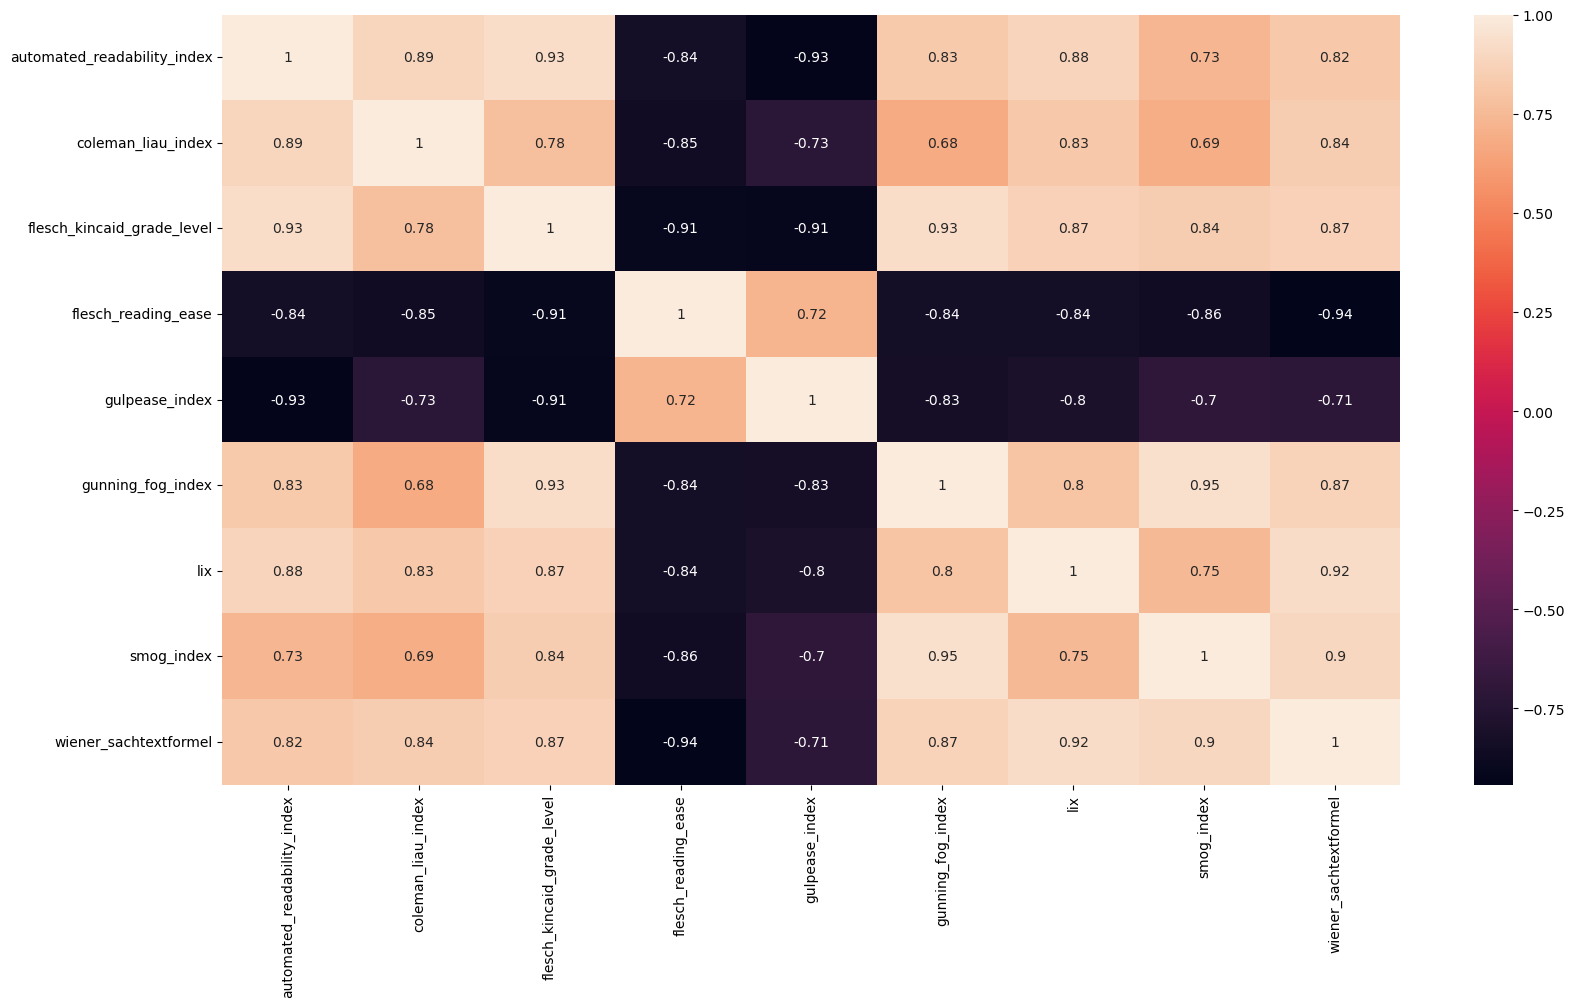

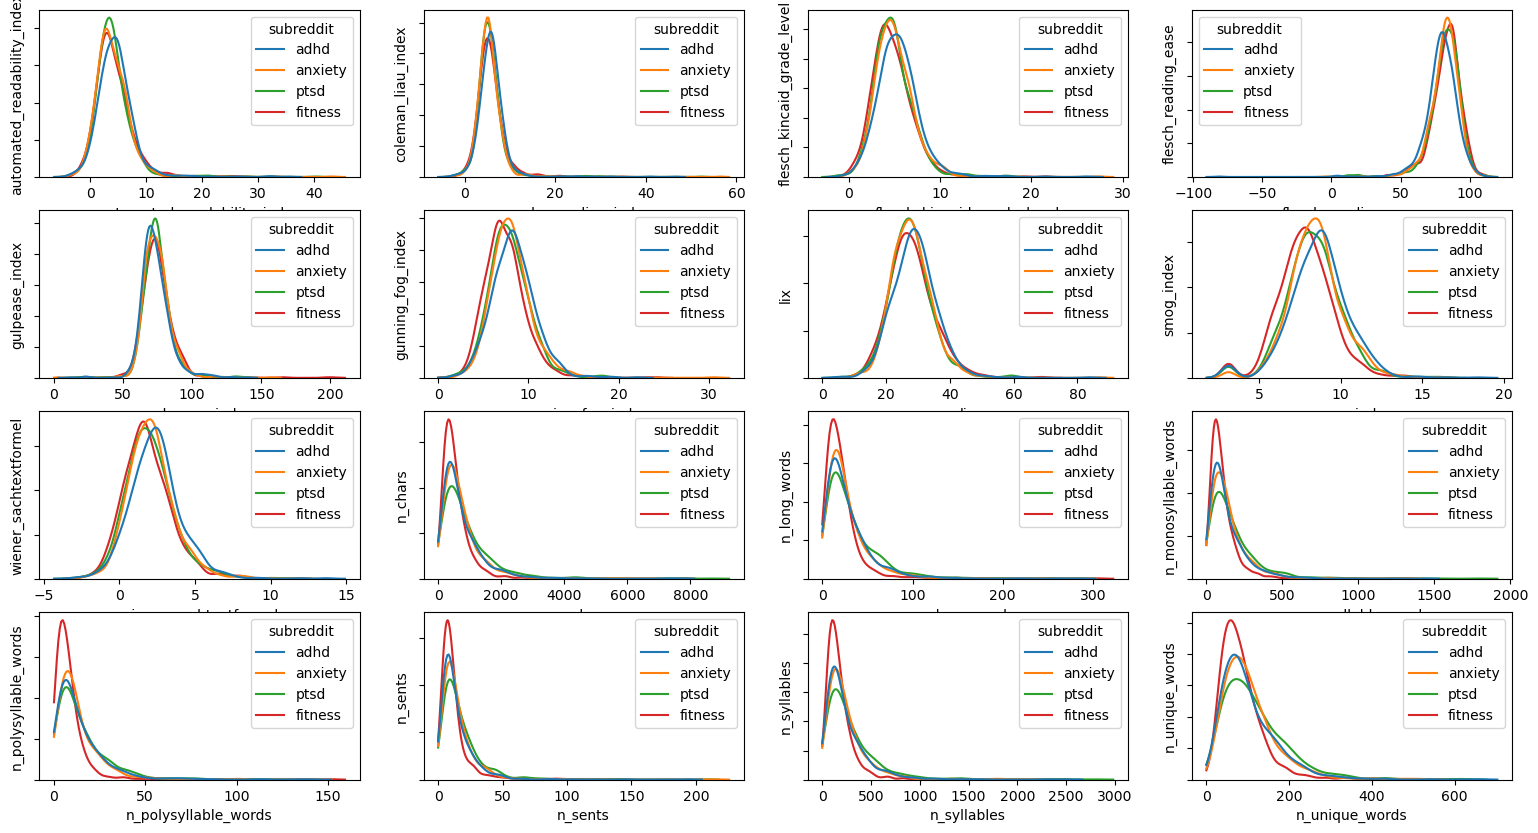

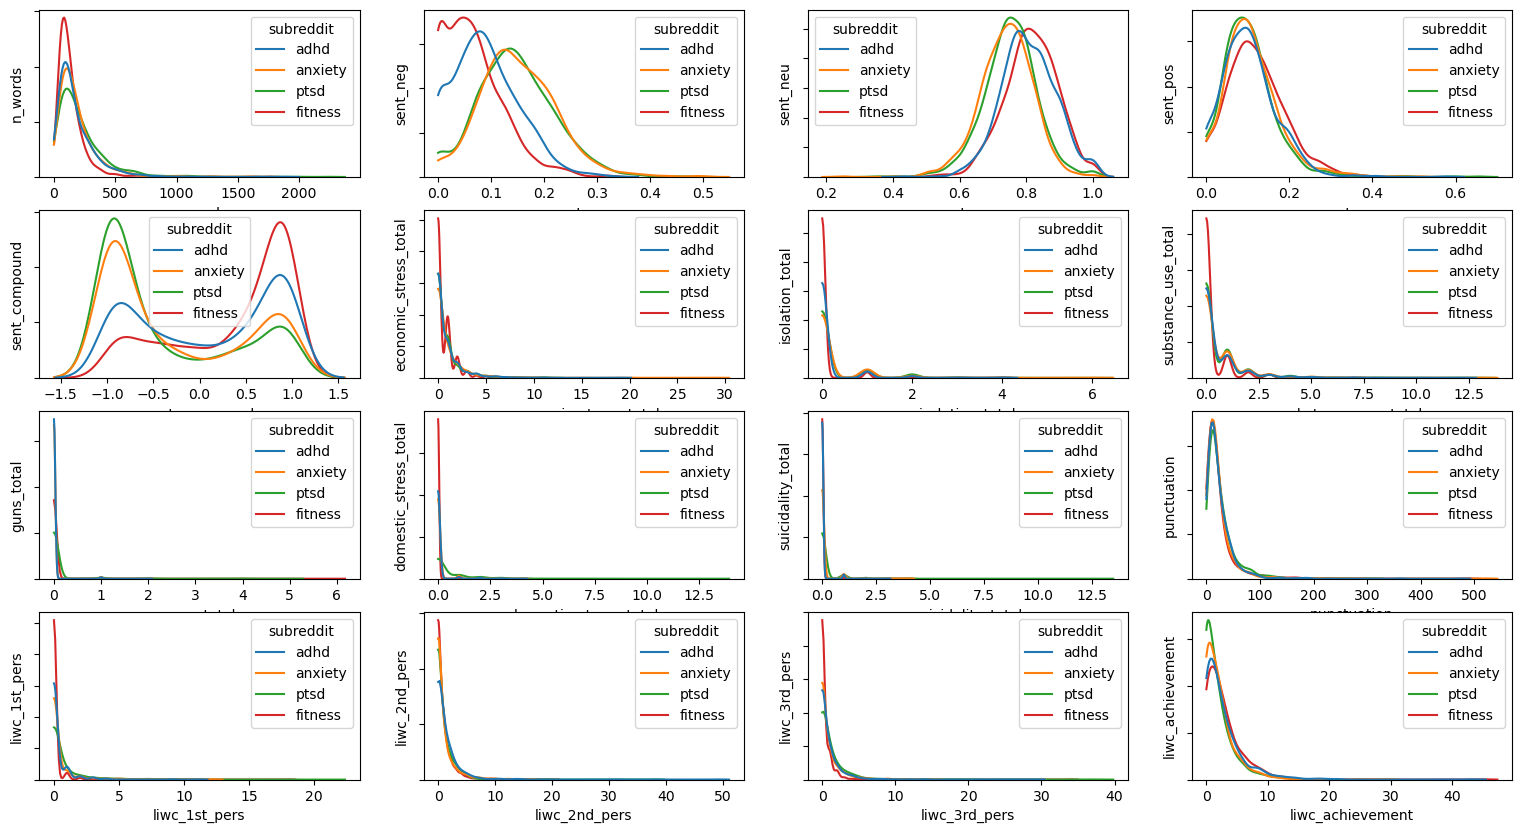

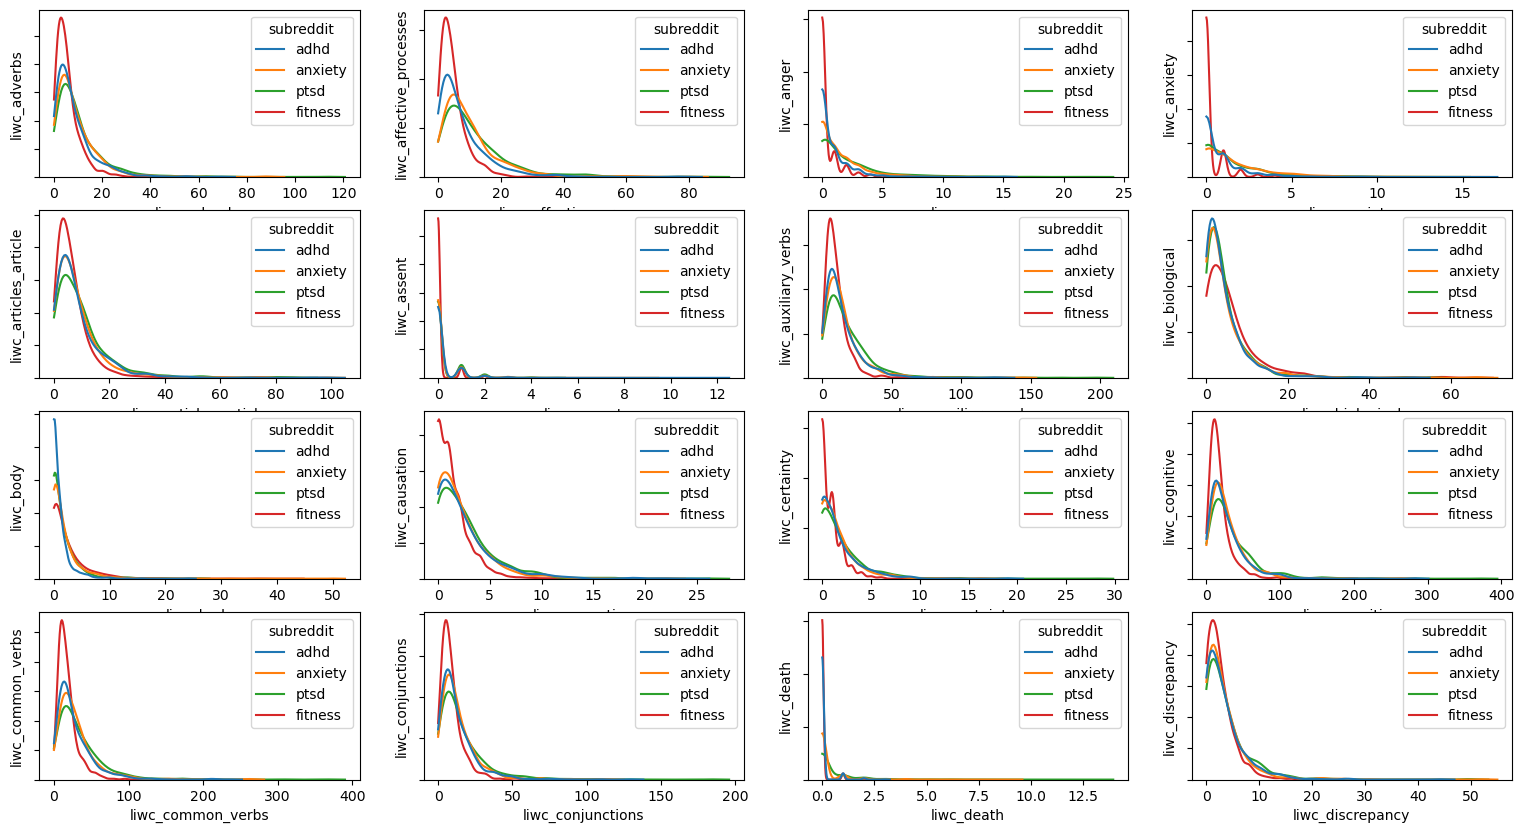

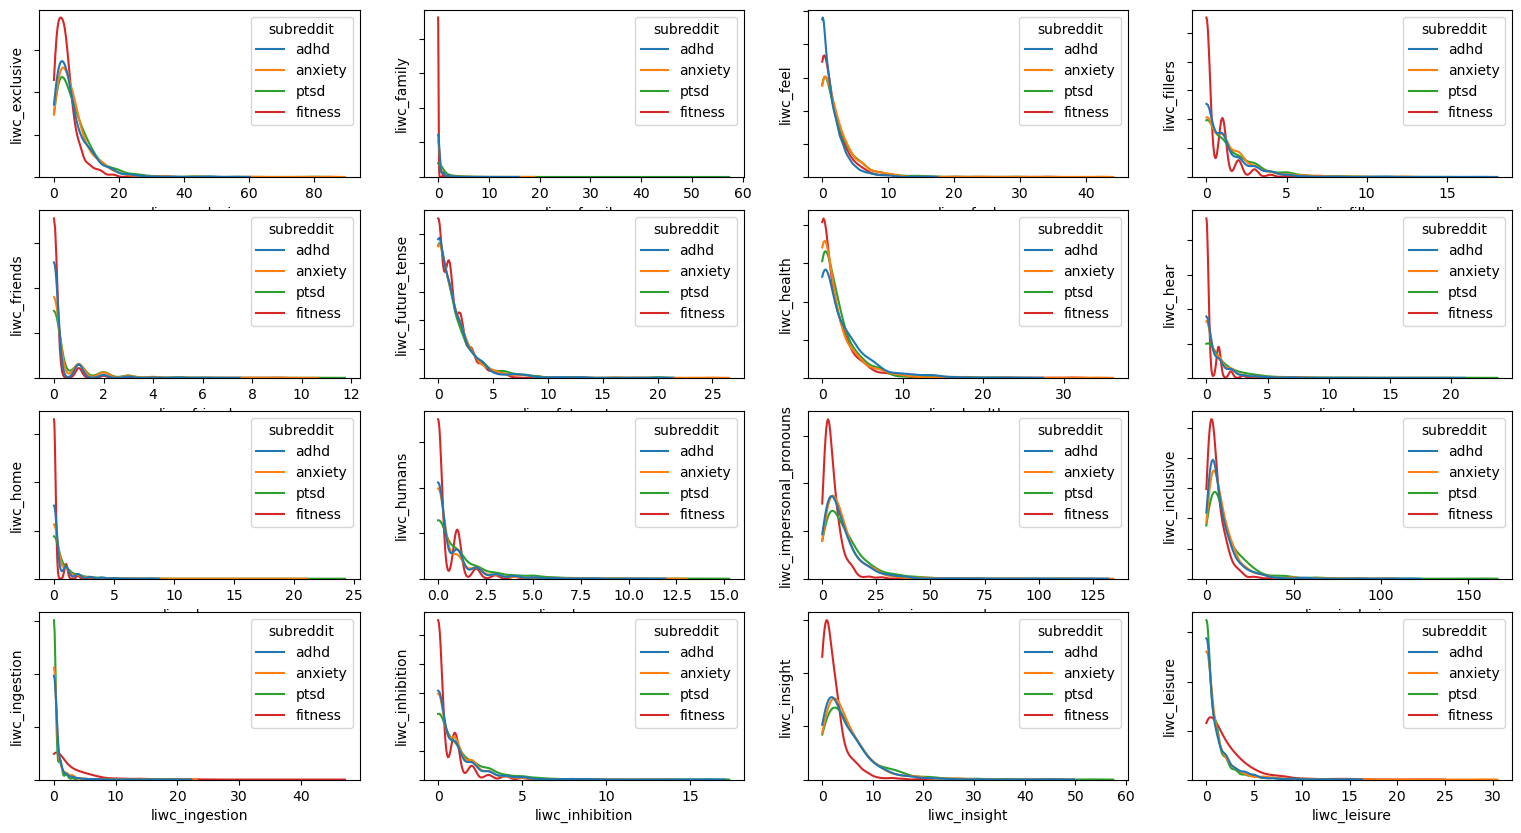

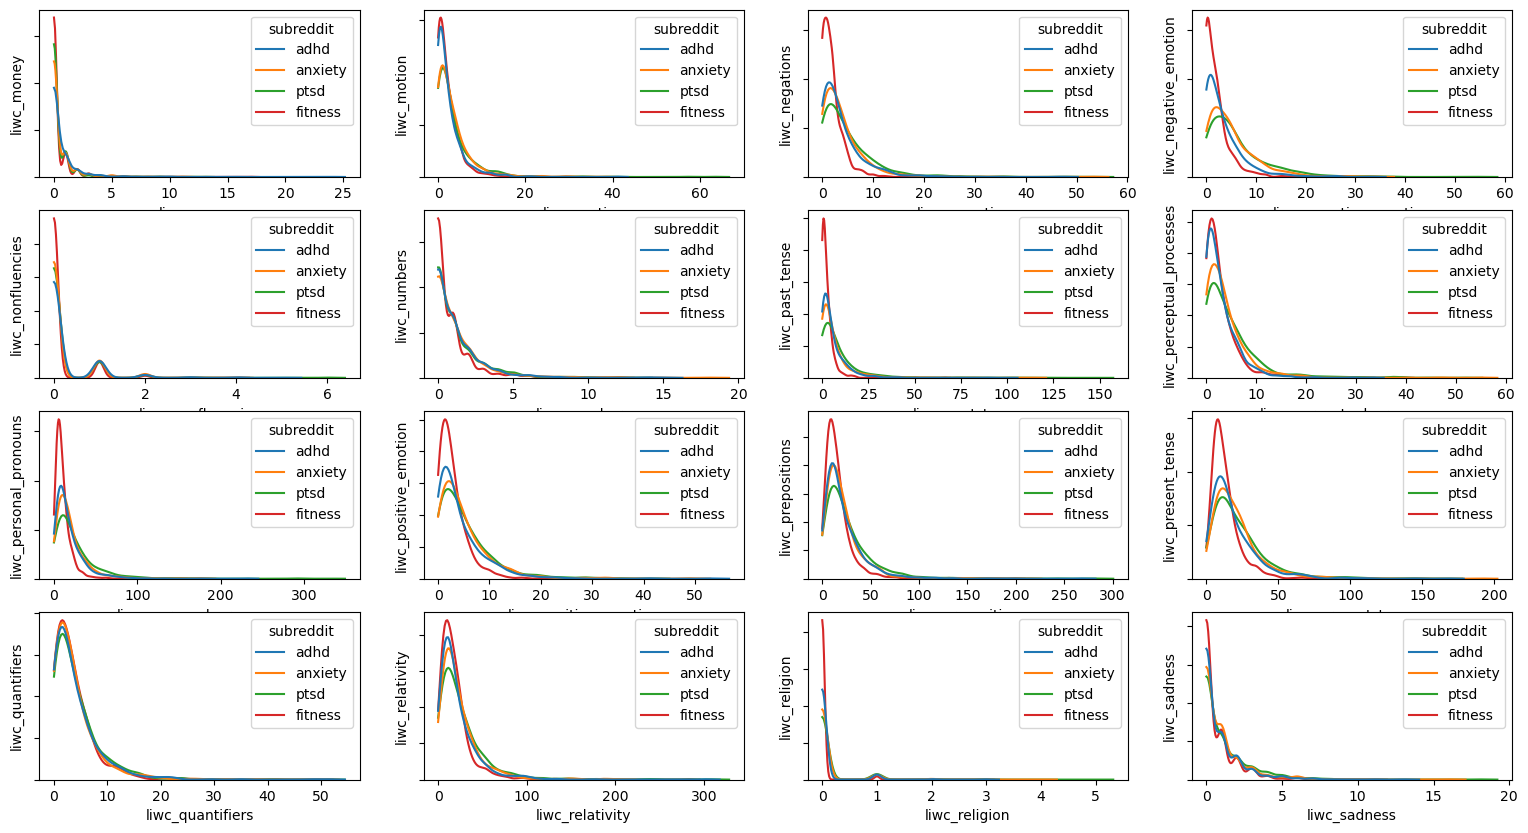

/var/folders/sn/jzn6dhwx1fvffctzvw3kftxw0000gn/T/ipykernel_3696/2533982917.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)


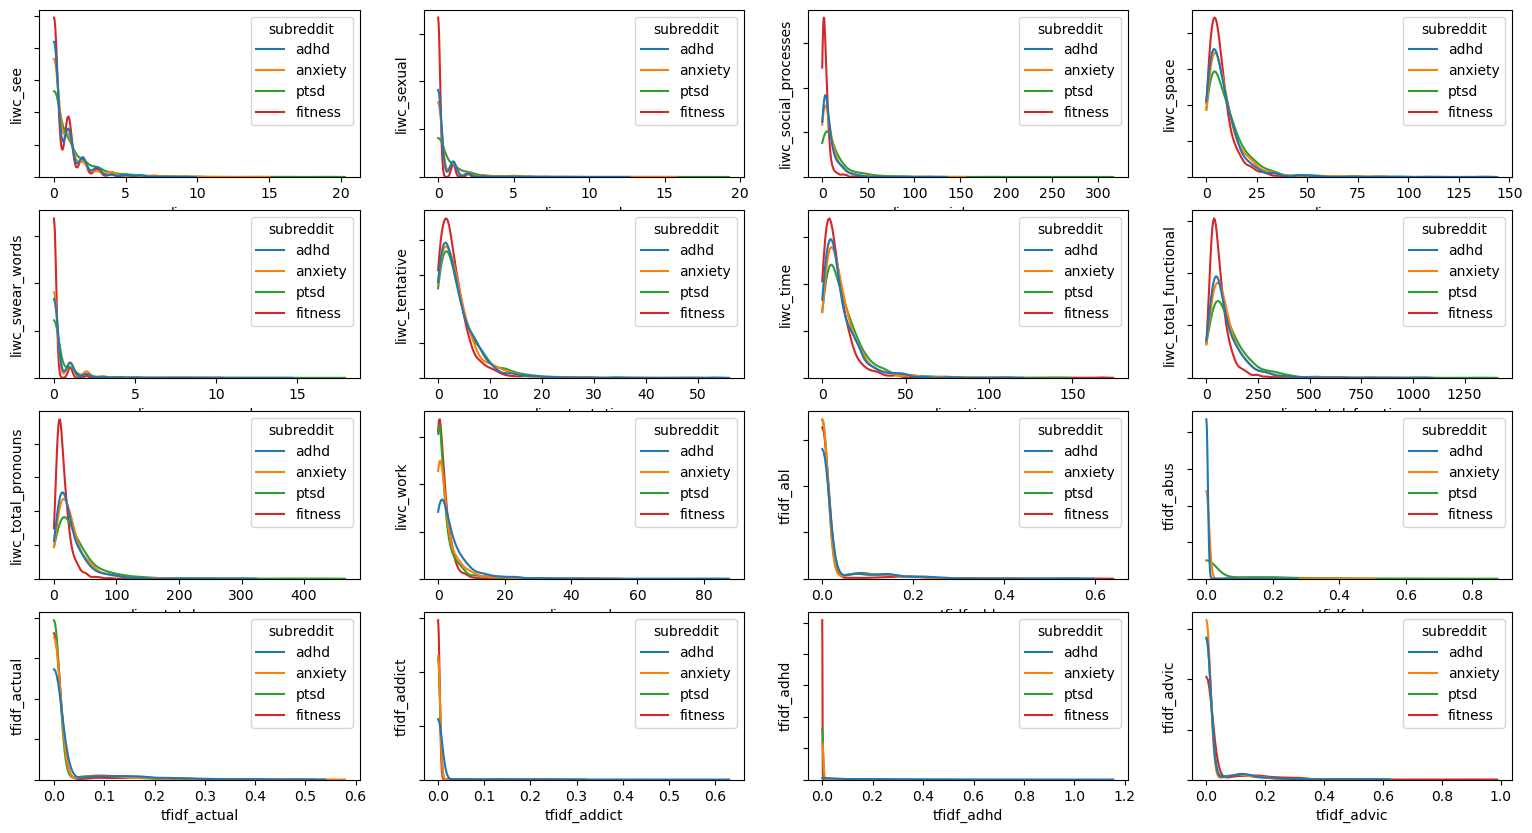

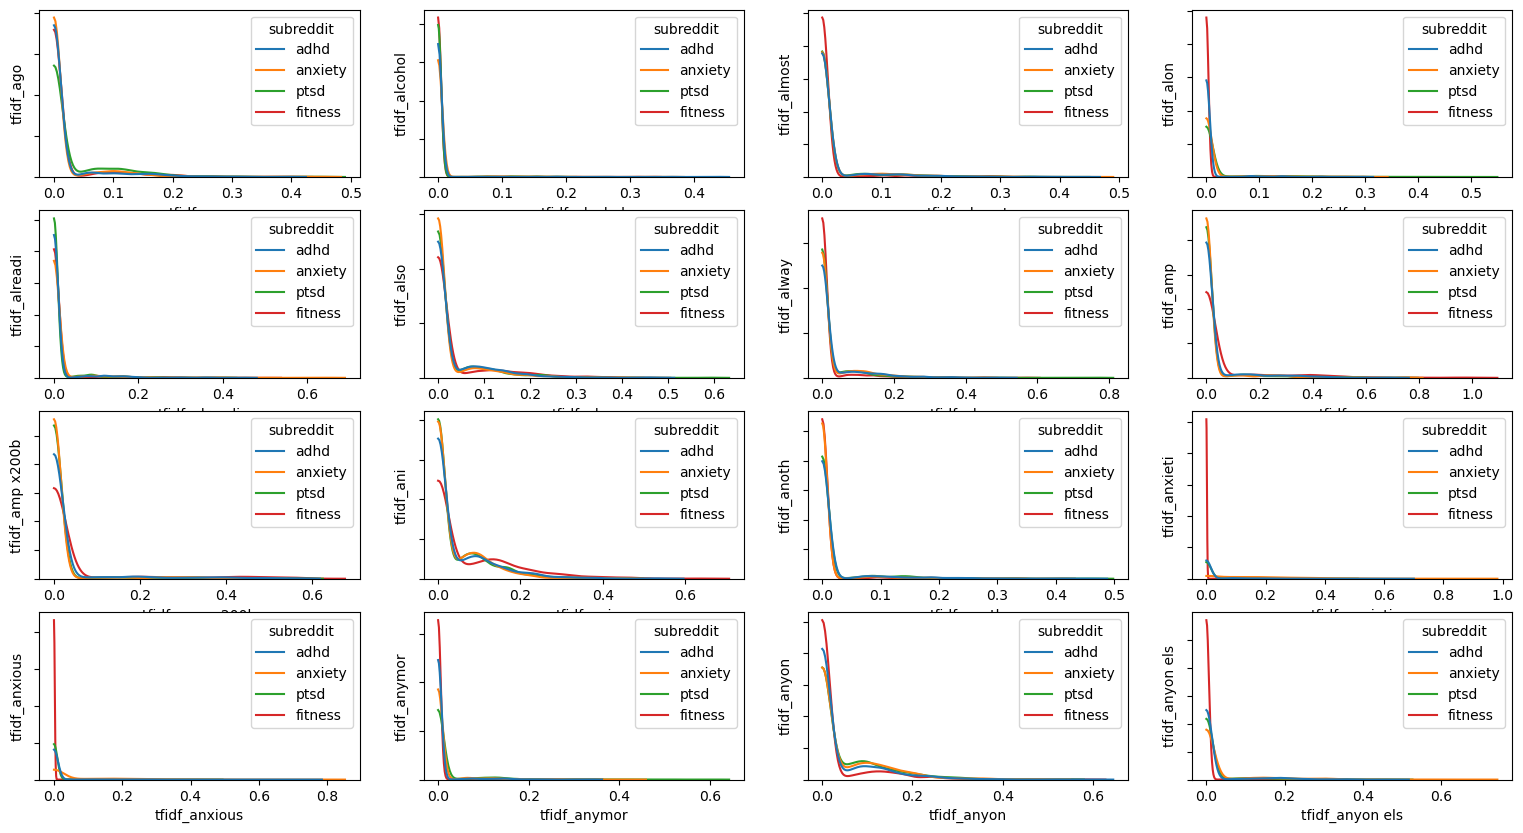

/var/folders/sn/jzn6dhwx1fvffctzvw3kftxw0000gn/T/ipykernel_3696/2533982917.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)
/var/folders/sn/jzn6dhwx1fvffctzvw3kftxw0000gn/T/ipykernel_3696/2533982917.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)


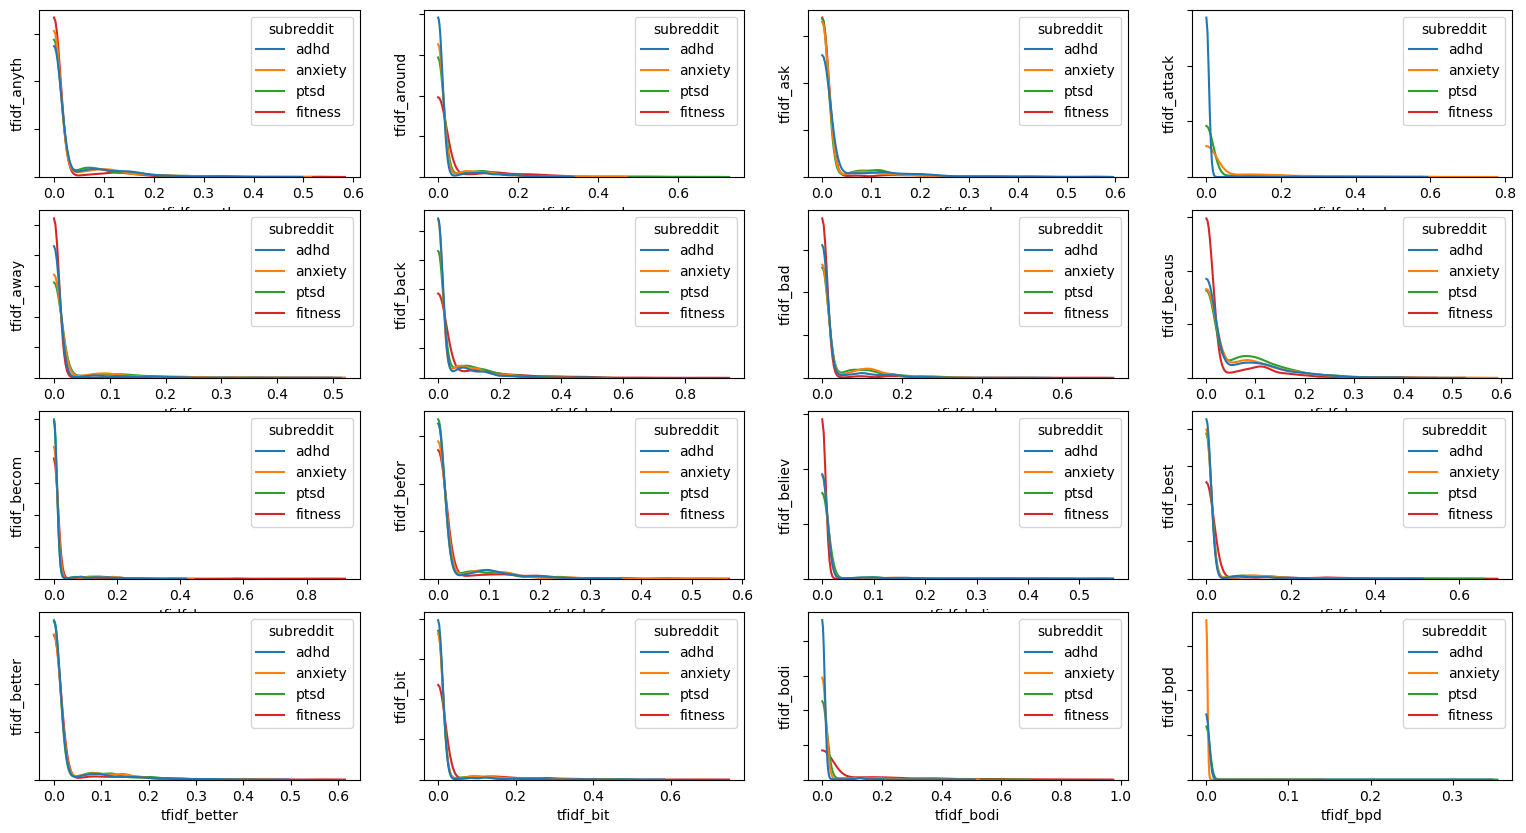

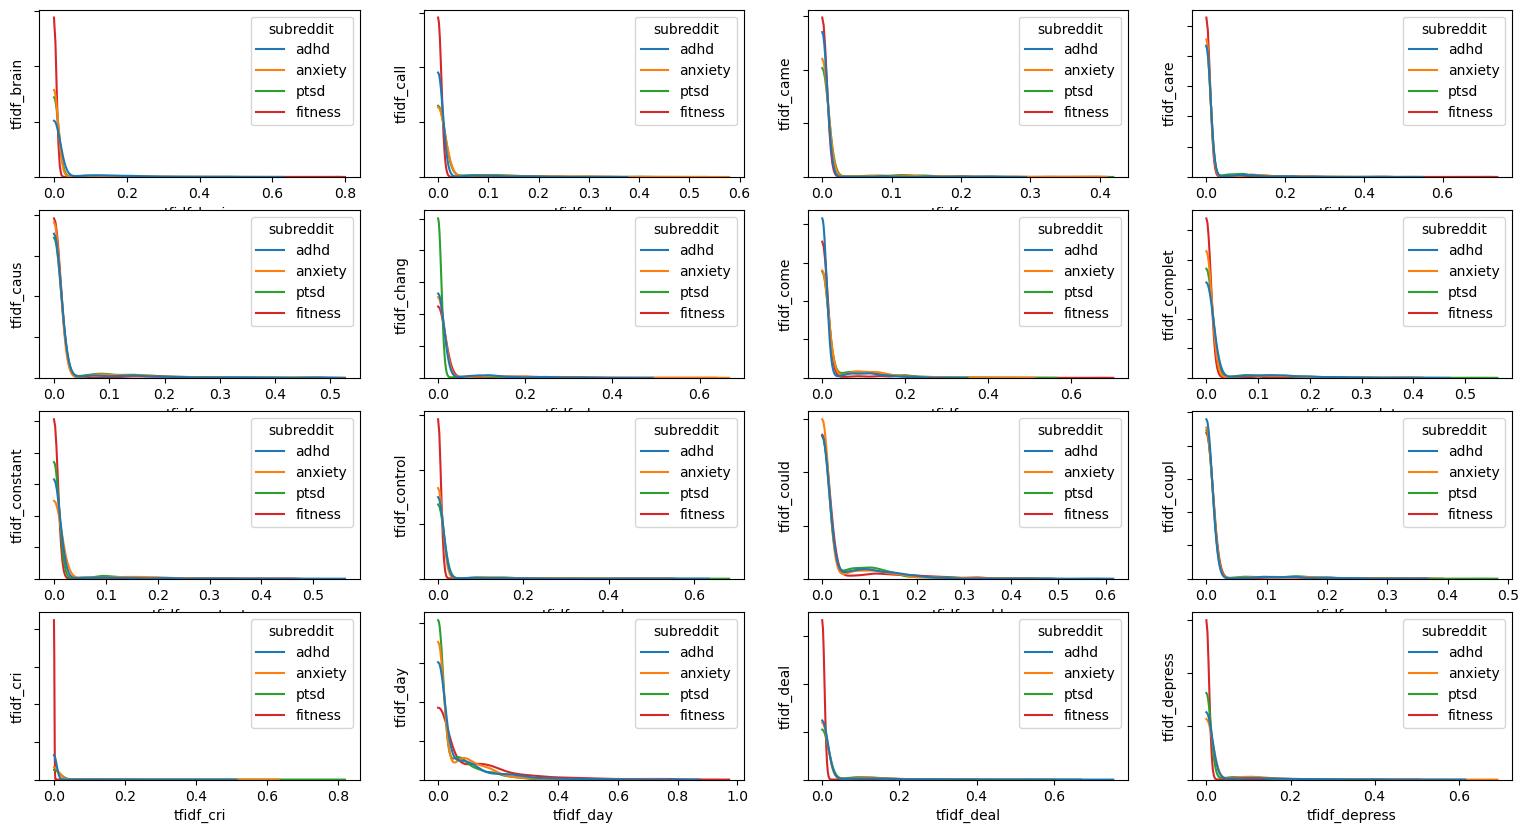

/var/folders/sn/jzn6dhwx1fvffctzvw3kftxw0000gn/T/ipykernel_3696/2533982917.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)


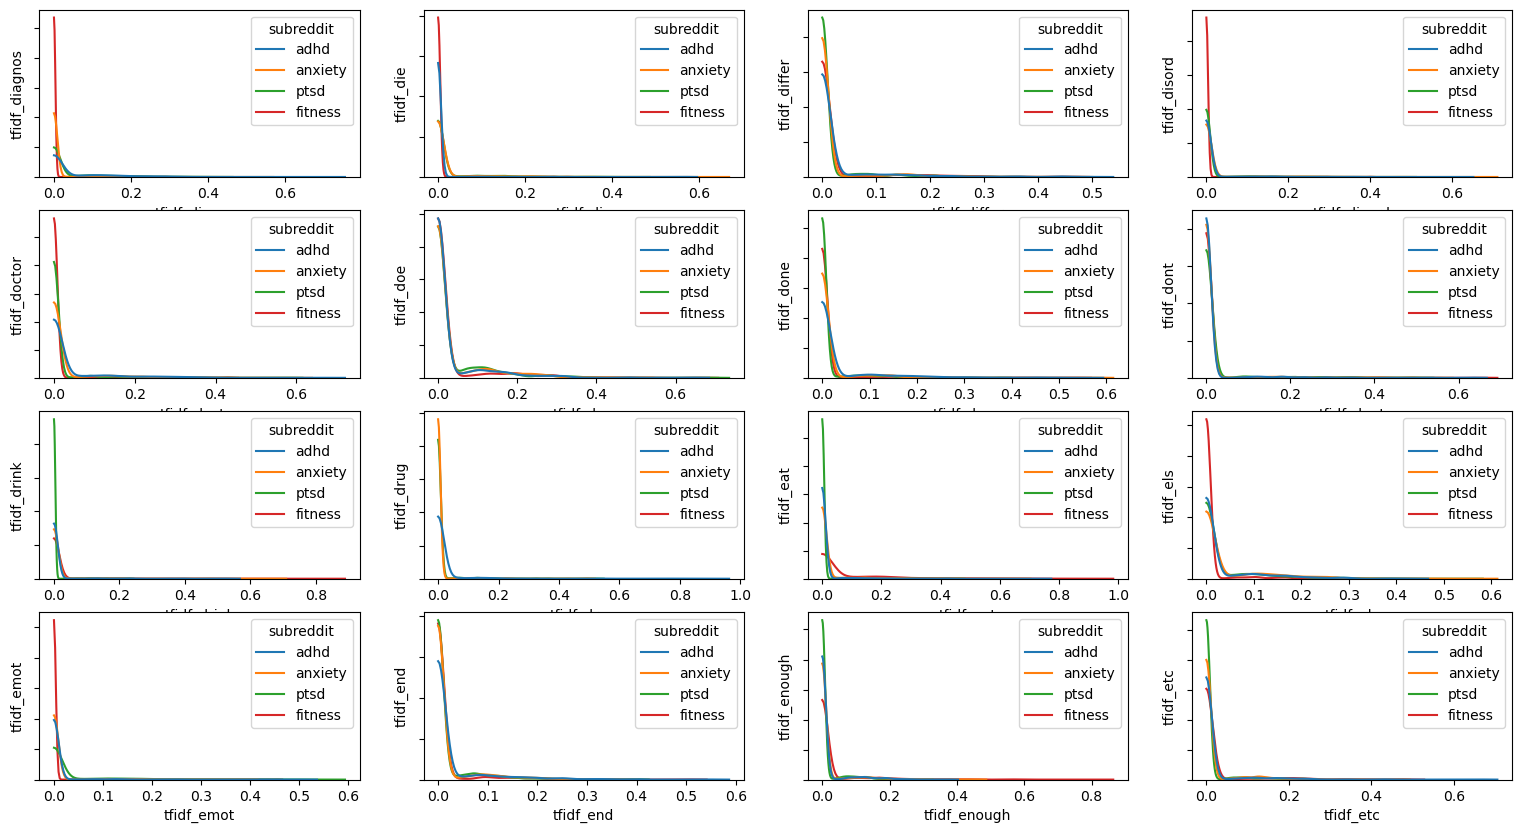

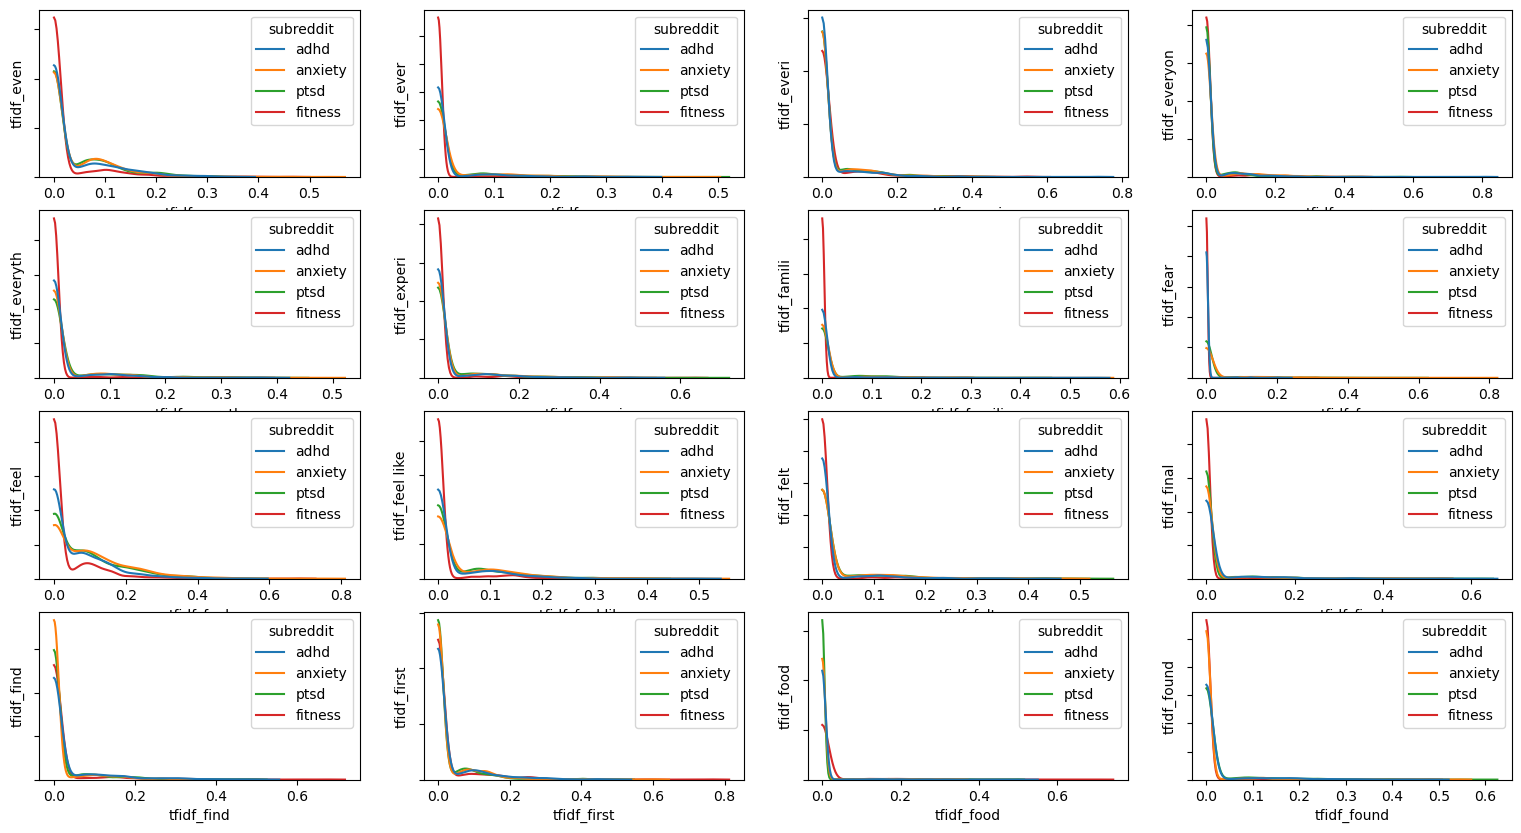

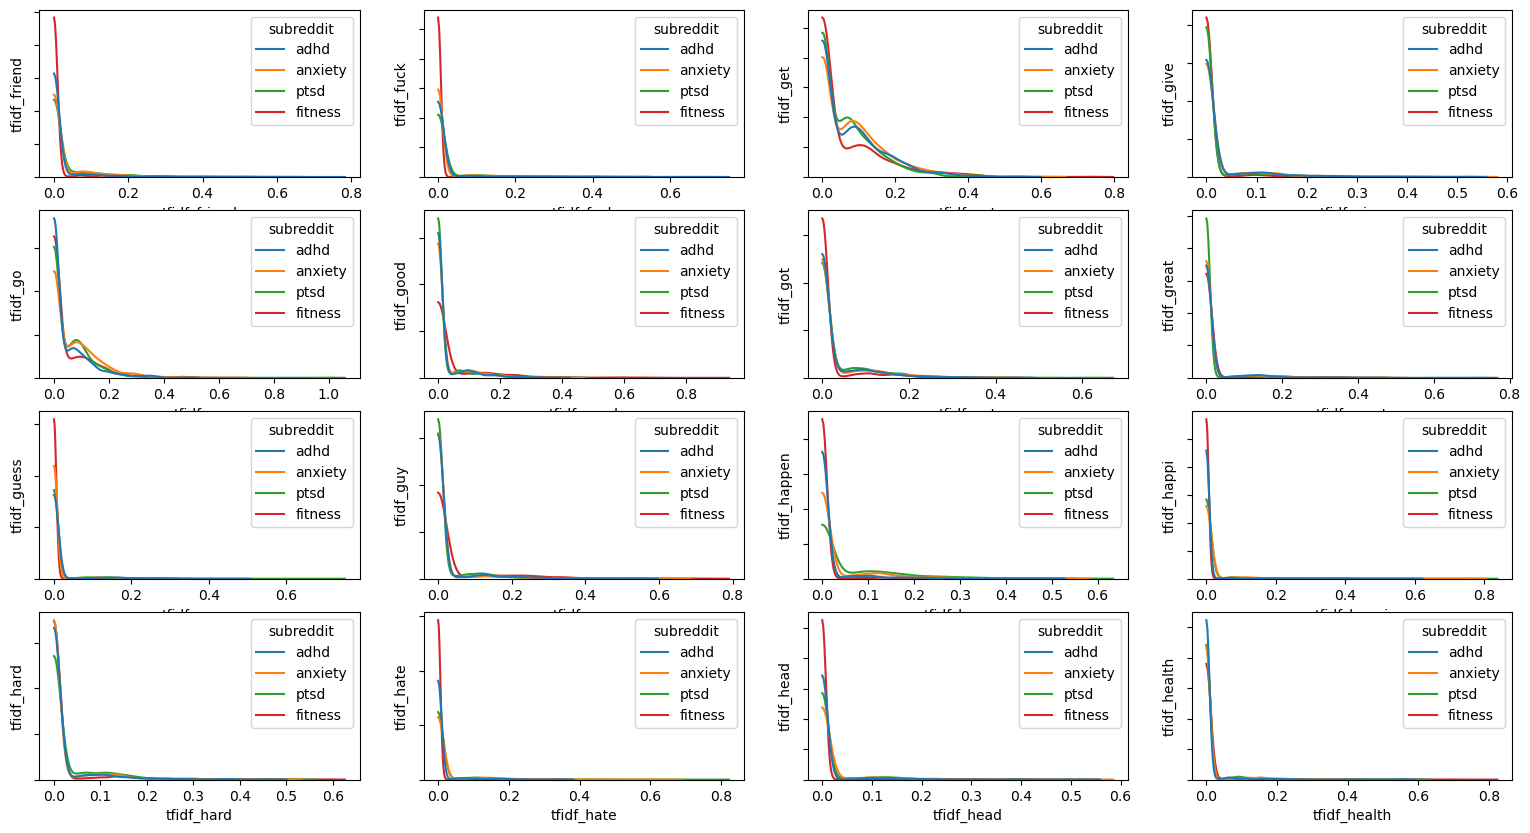

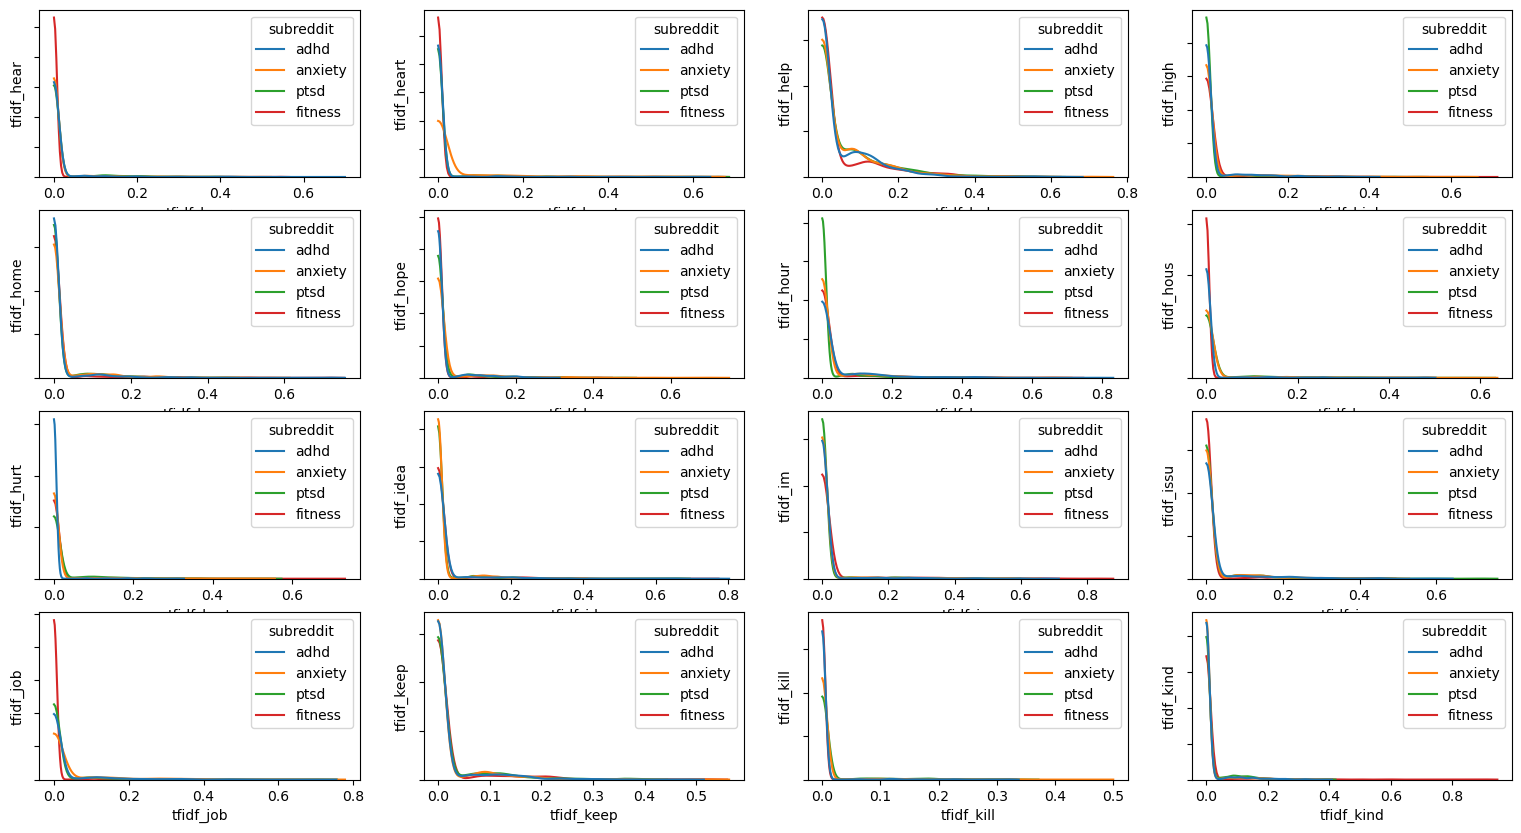

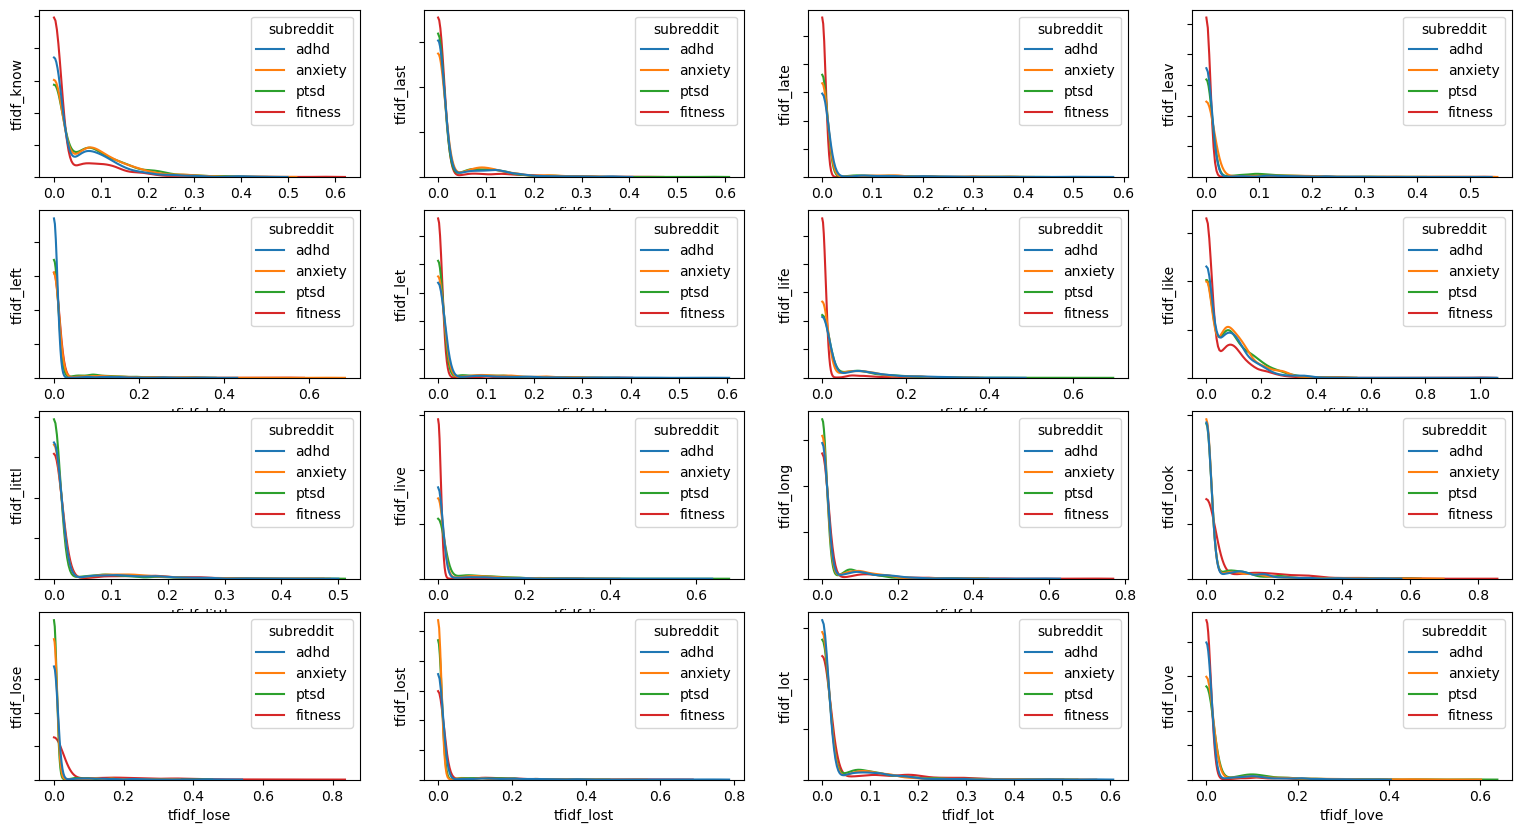

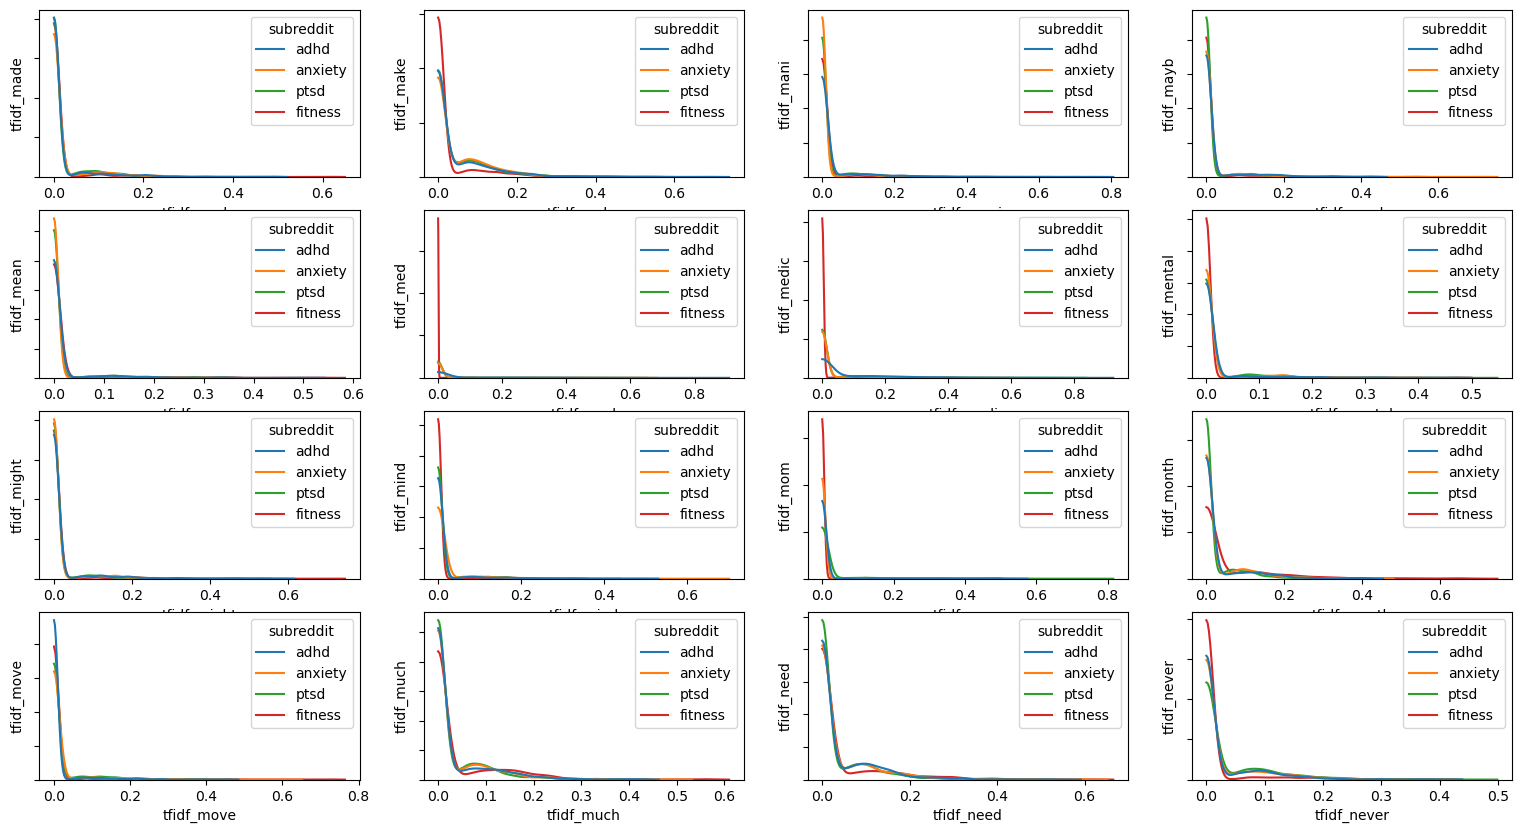

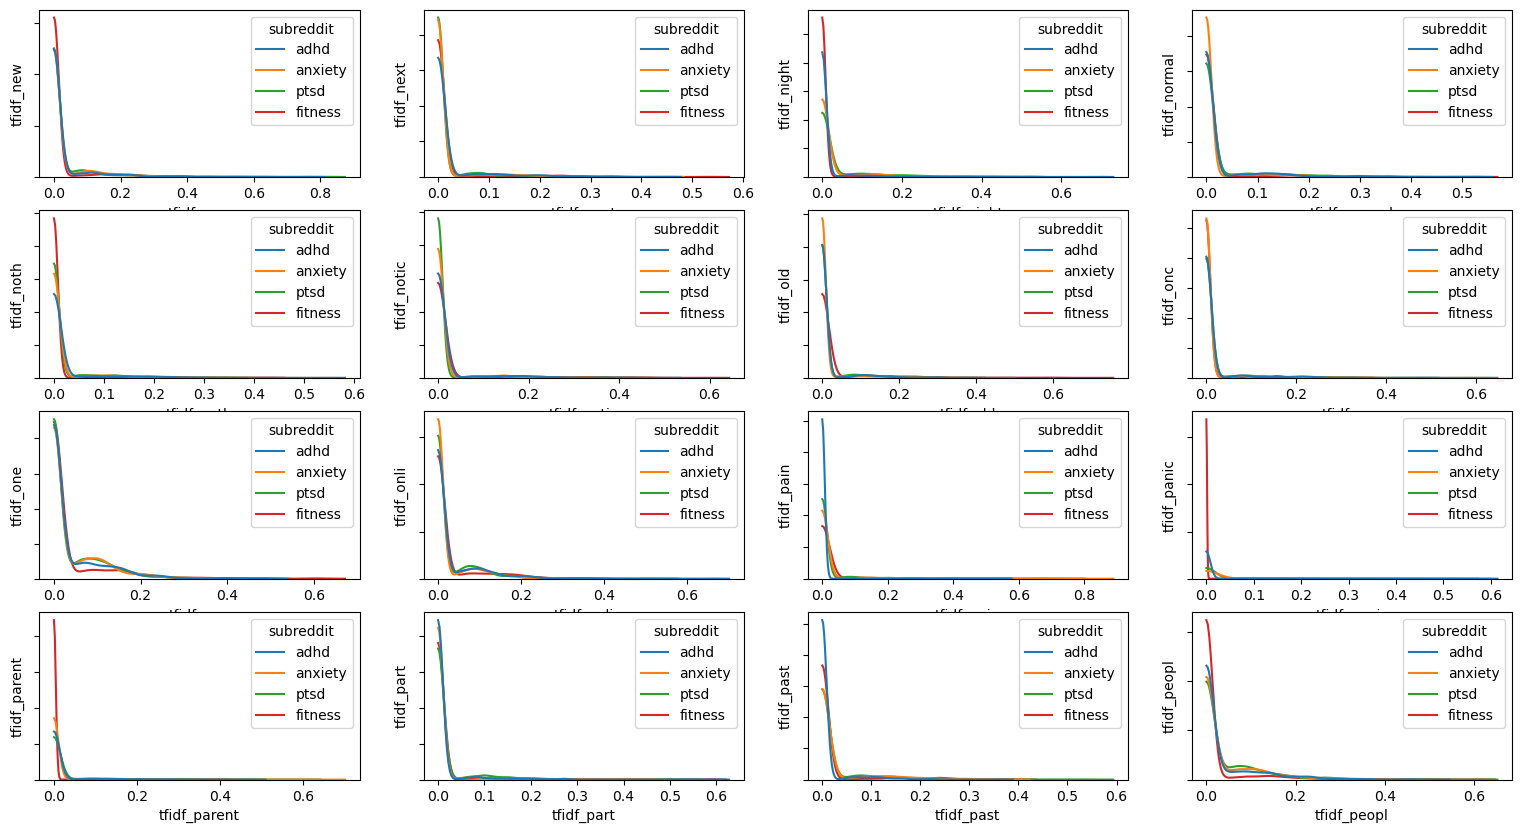

/var/folders/sn/jzn6dhwx1fvffctzvw3kftxw0000gn/T/ipykernel_3696/2533982917.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)


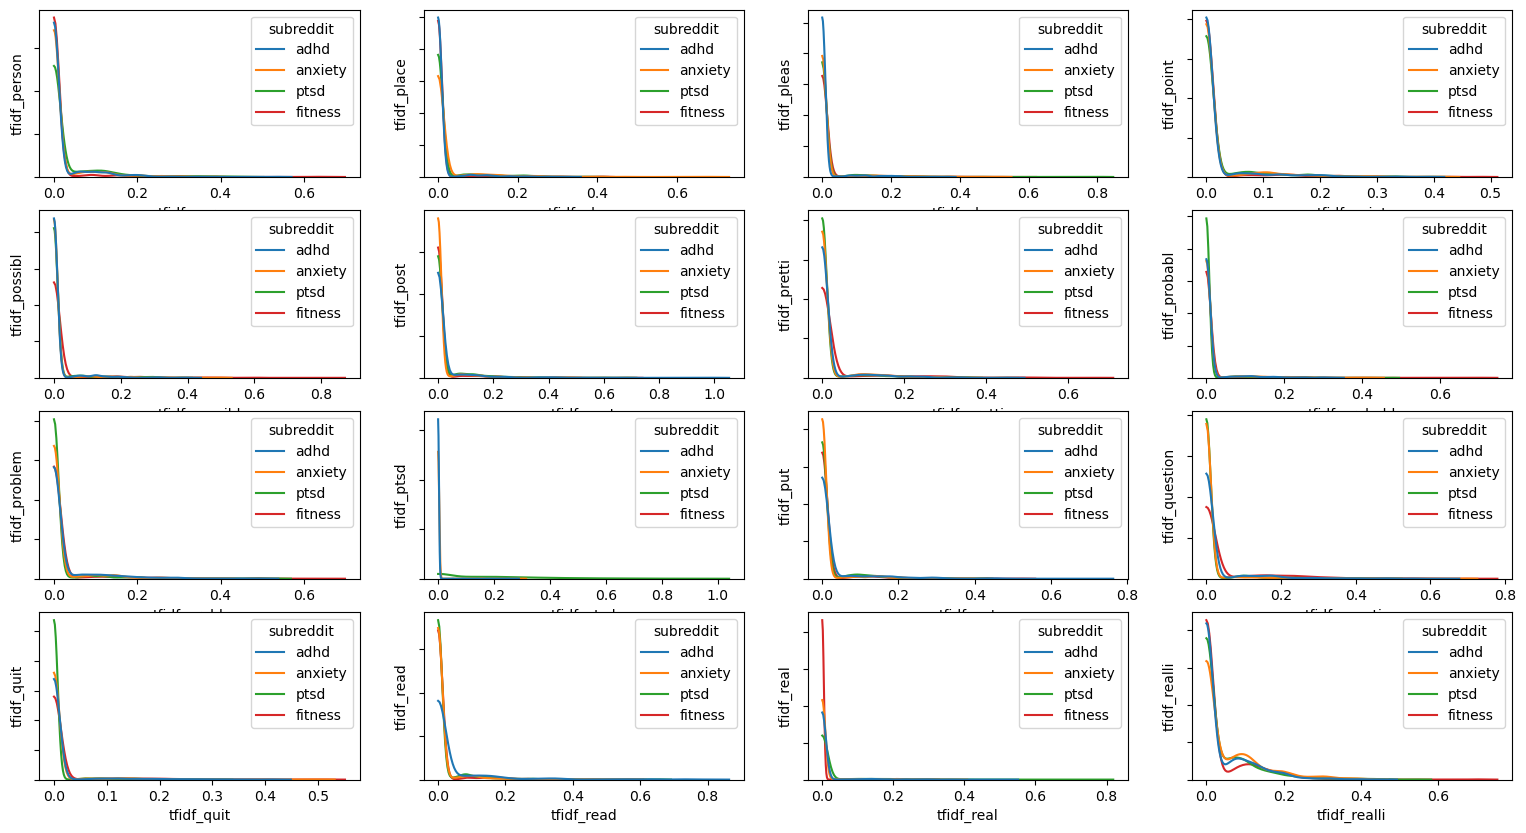

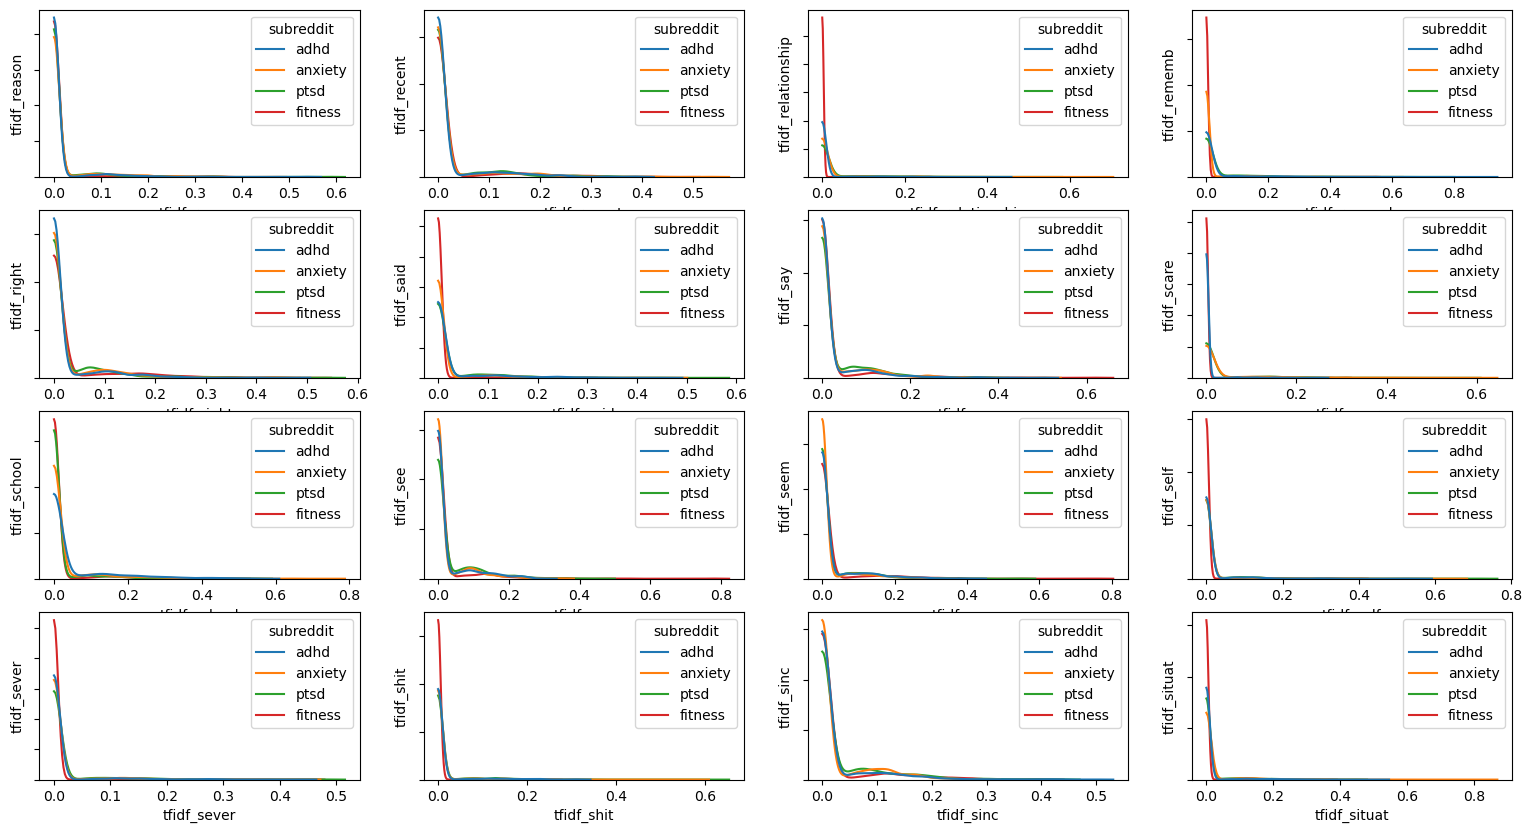

/var/folders/sn/jzn6dhwx1fvffctzvw3kftxw0000gn/T/ipykernel_3696/2533982917.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)


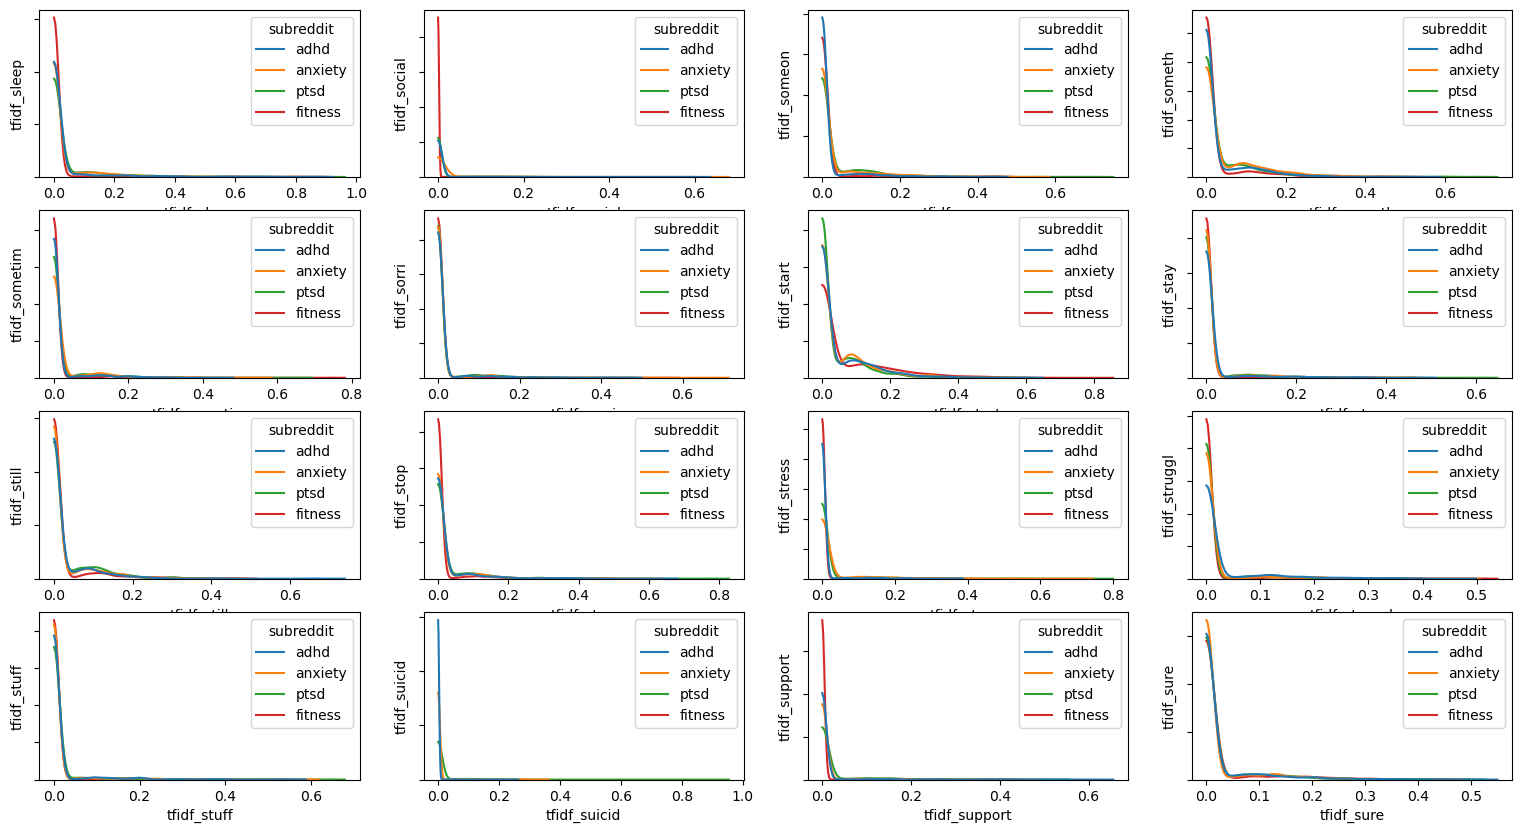

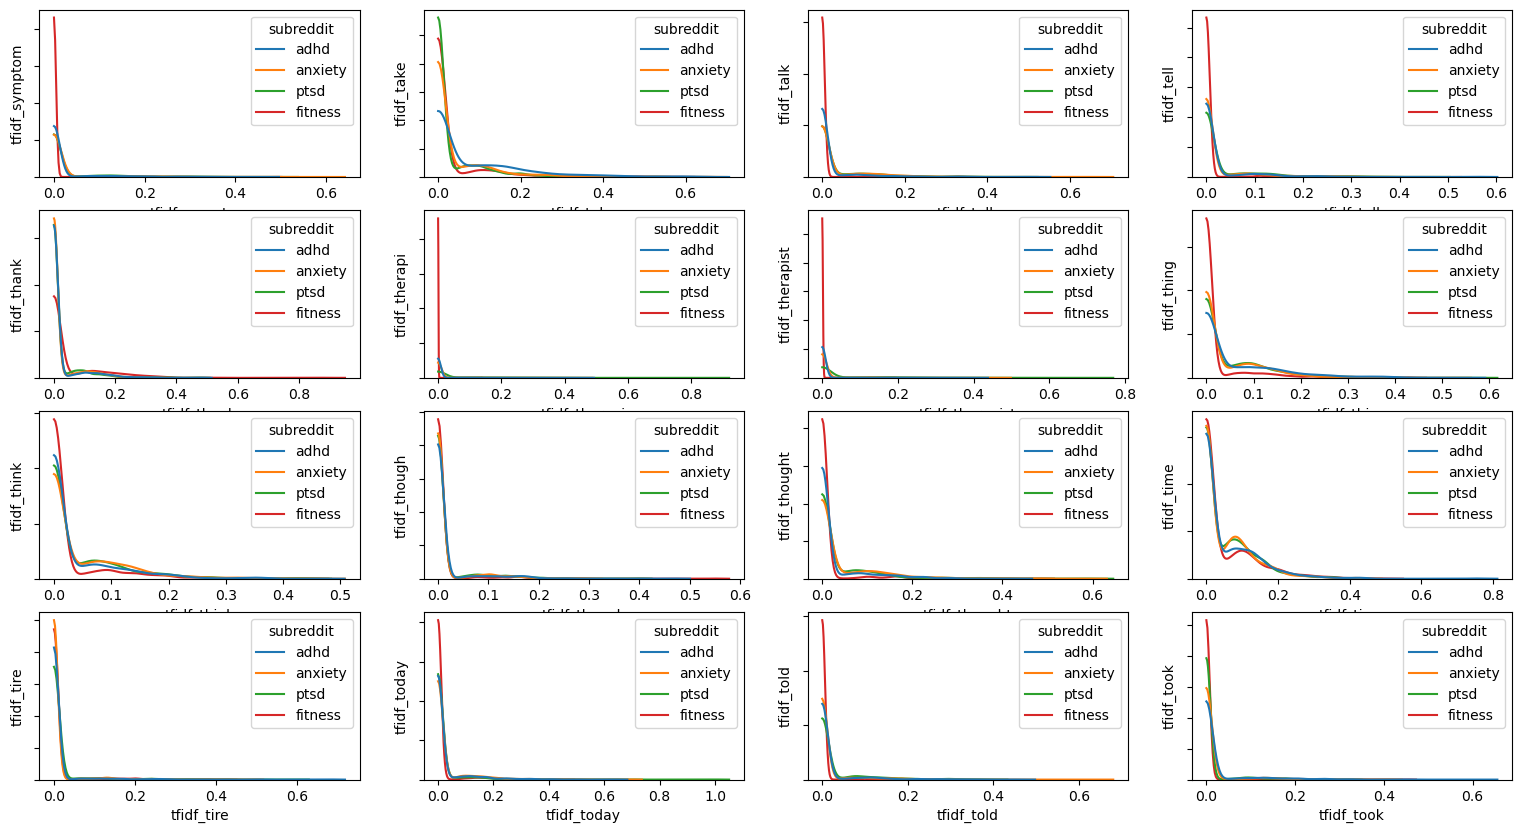

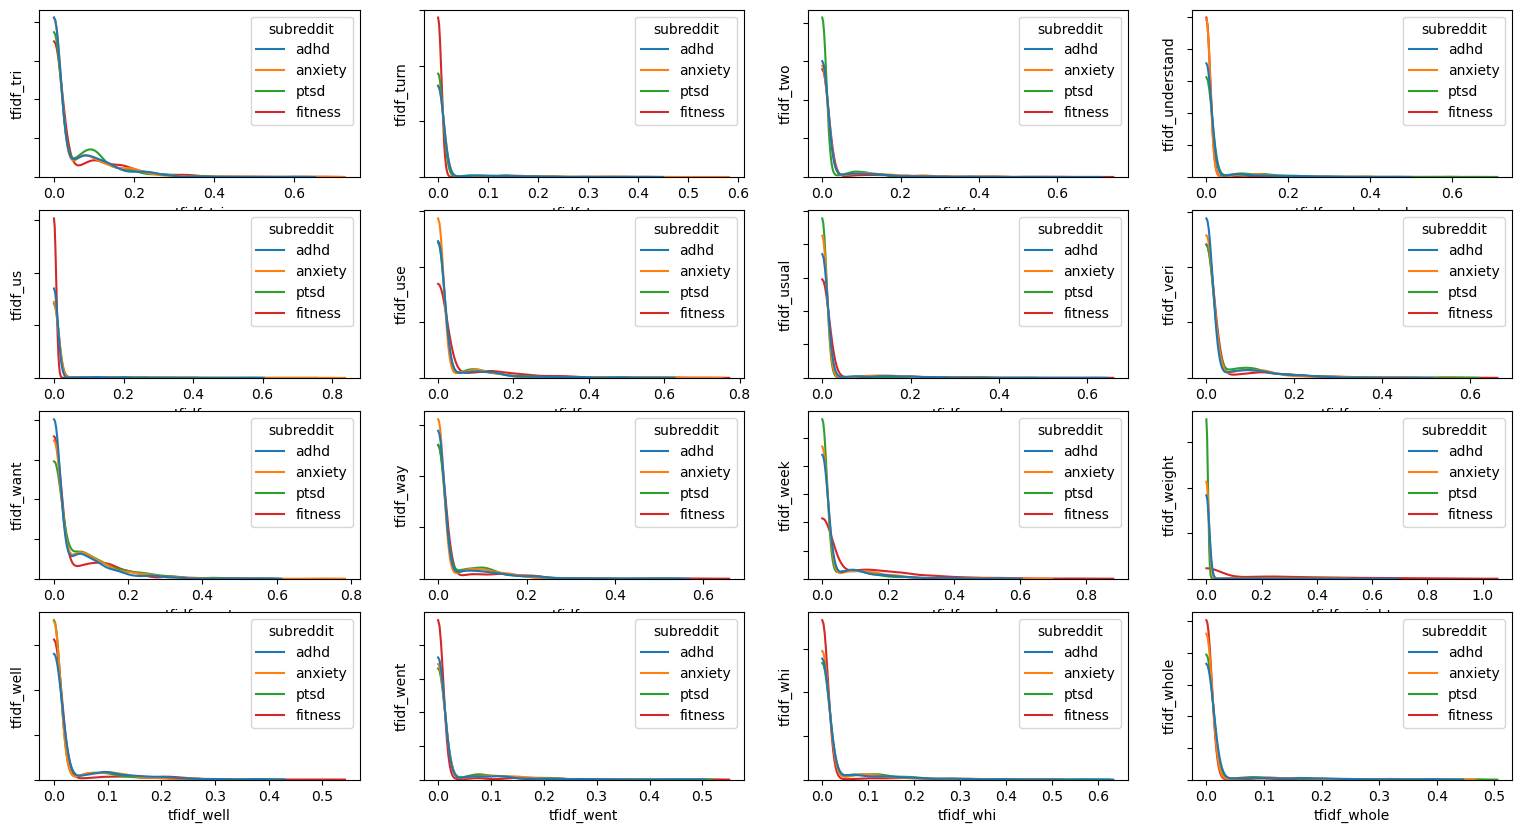

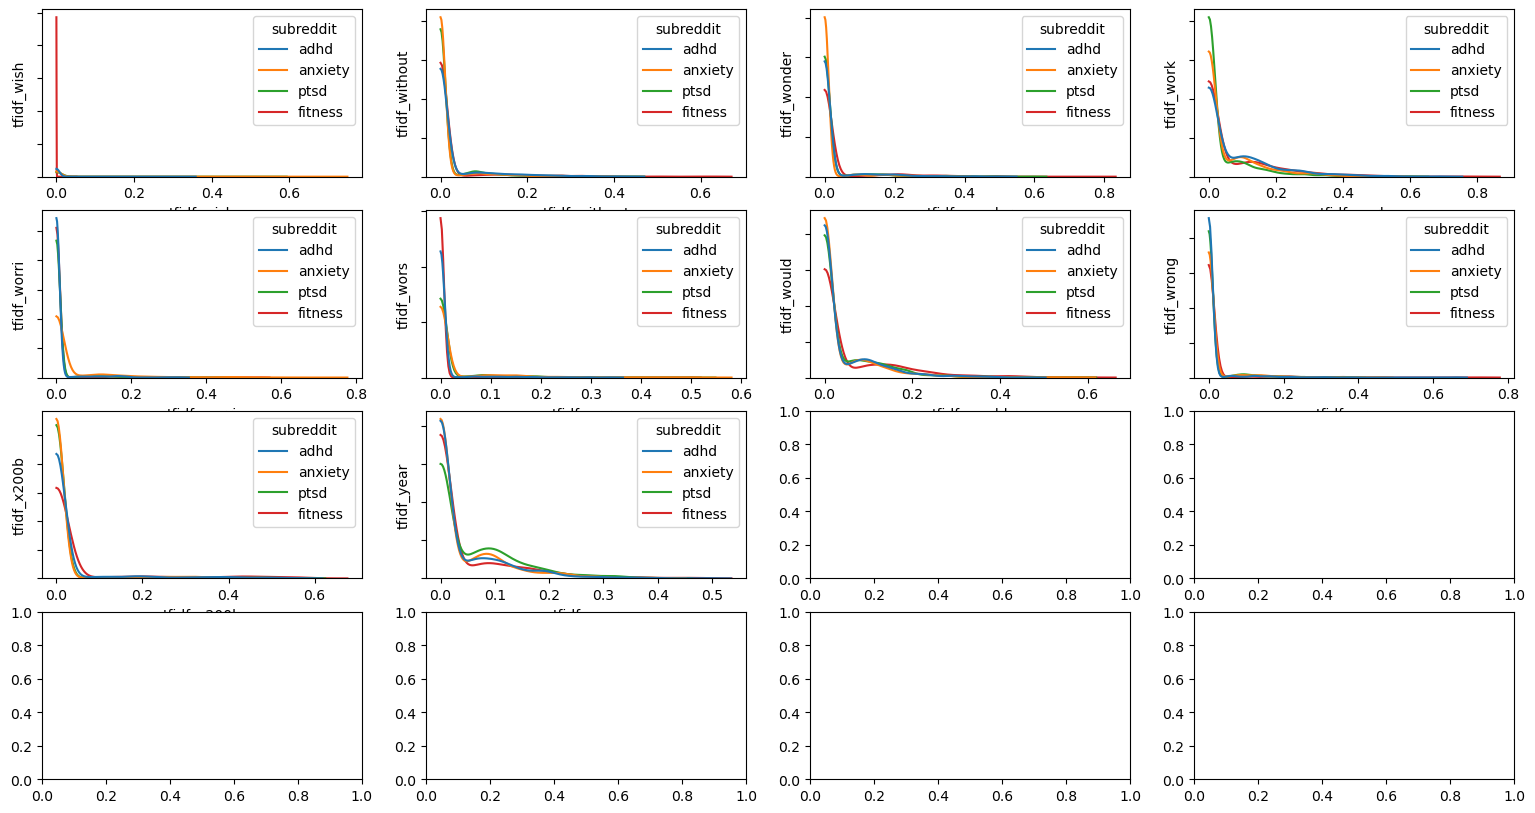

In [10]:
from matplotlib import rcParams
import math

rcParams['figure.figsize']=19,10

sns.heatmap(data=metrics_correlation,annot=True)
plt.show()

df_col_numeric=df_collected.select_dtypes(['int','float'])

df_col_numeric=pd.concat([df_col_numeric, df_collected.subreddit], axis=1)

df_col_1=df_col_numeric[df_col_numeric['subreddit']=='adhd'].sample(1000)
df_col_2=df_col_numeric[df_col_numeric['subreddit']=='anxiety'].sample(1000)
df_col_3=df_col_numeric[df_col_numeric['subreddit']=='ptsd'].sample(1000)
df_col_4=df_col_numeric[df_col_numeric['subreddit']=='fitness'].sample(1000)
df_col_numeric=pd.concat([df_col_1,df_col_2,df_col_3,df_col_4],axis=0)

non_neg_col=[i for i in df_col_numeric.drop('subreddit',axis=1) if np.min(df_col_numeric[i])>=0]


axs=plt.subplots(4,4)
for k,i in enumerate(df_col_numeric.columns):

    if i in ['target_val','subreddit']:
        continue
    if k%16==0 and k!=0:
        plt.show()
        axs=plt.subplots(4,4)

    if i not in non_neg_col:
        sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', ax=axs[1].flatten()[k%16],legend=True)
    else:
        sns.kdeplot(x=i,data=df_col_numeric, hue='subreddit', clip=(0,None), ax=axs[1].flatten()[k%16],legend=True)

    axs[1].flatten()[k%16].set_yticklabels([])
    axs[1].flatten()[k%16].set_ylabel(i)

    #sns.boxplot(y=i,x='subreddit',data=df_col_numeric, hue='subreddit', orient='v', ax=axs[1].flatten()[k%16])
    #axs[1].flatten()[k%16].legend(['Min '+str(np.round(np.min(df_col_numeric[i]),2)) + \
    #           '\n Max '+str(np.round(np.max(df_col_numeric[i]),2))])
    #axs[1].flatten()[k%16].legend(['Min '+str(np.round(np.min(df_col_numeric[i]),2)) + \
    #           '\n Max '+str(np.round(np.max(df_col_numeric[i]),2))])

    

#### We may want to look at how TF-IDFs of individual terms correlate with most interesting metrics (like 'sent_neg', 'sent_neu','sent_compound') to gain some insights. Let's choose an arbitrary threshold of correlation, say, 0.1.

In [11]:
thr_hold=0.1
cor_comp=df_collected.filter(regex='(tfidf_[A-Za-z0-9]+)|sent_neg').corr().replace({1:0})
tfidf_corr=(cor_comp<-1*thr_hold)|(cor_comp>thr_hold)
sent_df1=tfidf_corr.loc[tfidf_corr['sent_neg']==True].sent_neg.reset_index()[['index']]

In [12]:
thr_hold=0.1
cor_comp=df_collected.filter(regex='(tfidf_[A-Za-z0-9]+)|sent_neu').corr().replace({1:0})
tfidf_corr=(cor_comp<-1*thr_hold)|(cor_comp>thr_hold)
sent_df2=tfidf_corr.loc[tfidf_corr['sent_neu']==True].sent_neu.reset_index()[['index']]

In [13]:
thr_hold=0.1
cor_comp=df_collected.filter(regex='(tfidf_[A-Za-z0-9]+)|sent_compound').corr().replace({1:0})
tfidf_corr=(cor_comp<-1*thr_hold)|(cor_comp>thr_hold)
sent_df3=tfidf_corr.loc[tfidf_corr['sent_compound']==True].sent_compound.reset_index()[['index']]

#### The most interesting TF-IDF features are mainly associated with all sentiment metrics. Lets combine all of them to see.

In [14]:
sent_df_words=pd.concat([sent_df1,sent_df2,sent_df3],axis=0).drop_duplicates()
sent_df_words=np.array(sent_df_words['index'].to_list()).reshape(-1,46)
sent_df_words

array([['tfidf_alon', 'tfidf_ani', 'tfidf_anxieti', 'tfidf_anxious',
        'tfidf_attack', 'tfidf_bad', 'tfidf_becaus', 'tfidf_constant',
        'tfidf_cri', 'tfidf_day', 'tfidf_depress', 'tfidf_die',
        'tfidf_even', 'tfidf_fear', 'tfidf_feel', 'tfidf_feel like',
        'tfidf_fuck', 'tfidf_happen', 'tfidf_hate', 'tfidf_hurt',
        'tfidf_kill', 'tfidf_look', 'tfidf_pain', 'tfidf_panic',
        'tfidf_scare', 'tfidf_shit', 'tfidf_stop', 'tfidf_stress',
        'tfidf_suicid', 'tfidf_thank', 'tfidf_use', 'tfidf_week',
        'tfidf_weight', 'tfidf_worri', 'tfidf_wors', 'tfidf_would',
        'tfidf_wrong', 'tfidf_friend', 'tfidf_happi', 'tfidf_help',
        'tfidf_like', 'tfidf_love', 'tfidf_best', 'tfidf_good',
        'tfidf_great', 'tfidf_pretti']], dtype='<U15')

### Perform non-parametric tests to see how sentiment variables differ across conditions

#### These variables are non-normally distributed

List of p-values 
 [[9.92602704e-226 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [2.05057677e-138 0.00000000e+000 0.00000000e+000 0.00000000e+000]] 

Amount of normally distributed variables:  0


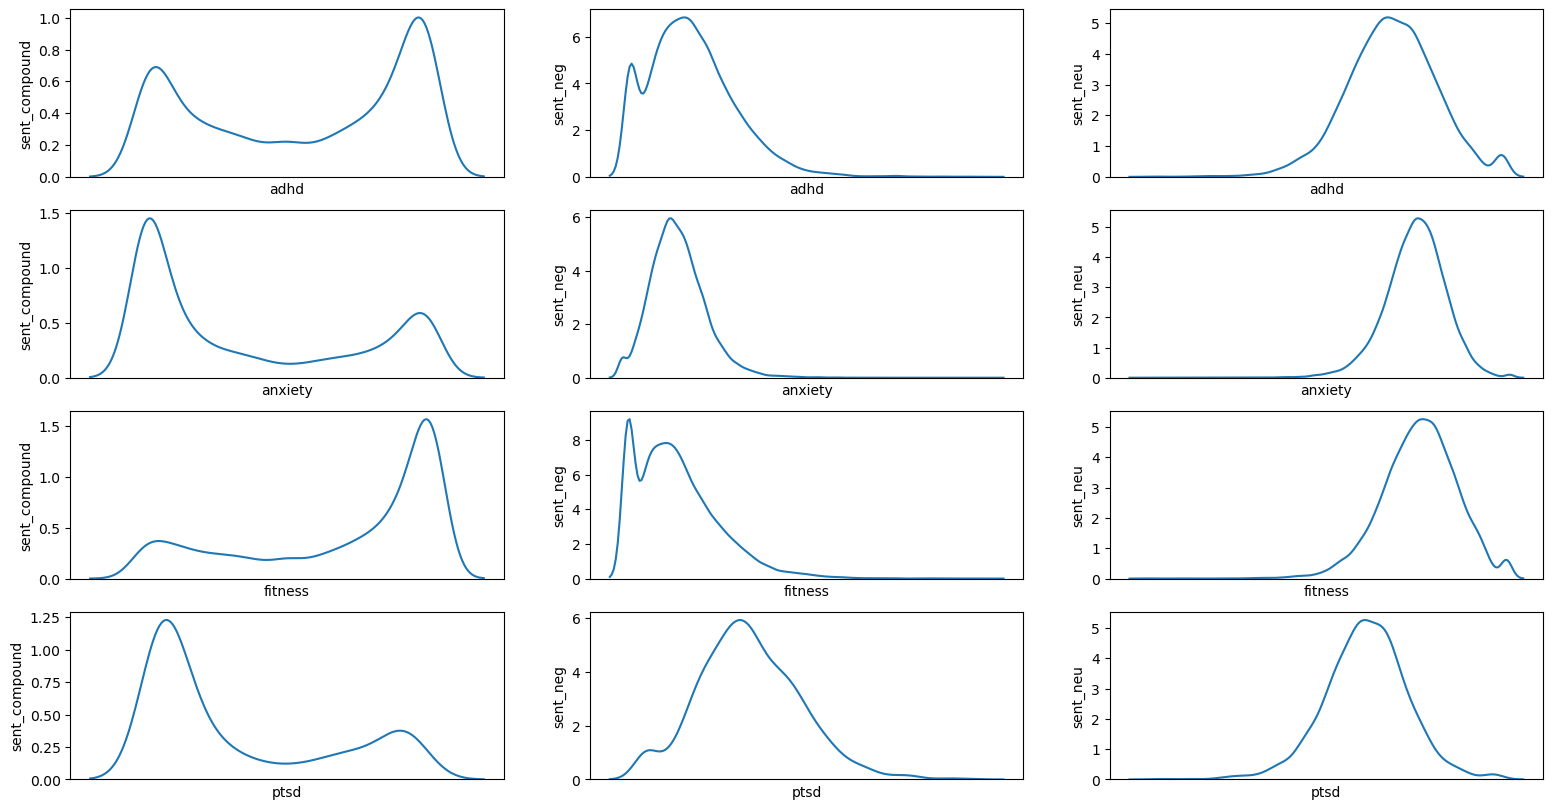

In [15]:
from matplotlib import rcParams

rcParams['figure.figsize']=19,10

statset=df_collected[['sent_compound','sent_neg','sent_neu','target_val']]

p_values_norm=np.zeros((4,len(statset.columns)))
lbls={0:'adhd',1:'anxiety',2:'fitness',3:'ptsd'}

axs=plt.subplots(4,3)
for i in range(4):
    sset=statset[statset.target_val==i].drop('target_val',axis=1)
    for c,k in enumerate(sset.columns):
        sns.kdeplot(data=sset[k],legend=k,ax=axs[1].flatten()[3*i+c%3])
        axs[1].flatten()[3*i+c%3].set_ylabel(k)
        axs[1].flatten()[3*i+c%3].set_xlabel(lbls[i])
        axs[1].flatten()[3*i+c%3].set_xticks([])
        p_values_norm[i,c]=kstest(sset[k],'norm')[1]

print('List of p-values','\n',p_values_norm,'\n')
print('Amount of normally distributed variables: ',(p_values_norm>0.05).sum())


#### From the looks above, we can see that PTSD and Anxiety tend to contain more negative sentiments, while ADHD seems to have both negative and positive emphasized.

In [16]:
from scipy.stats import describe
from scipy.stats import kruskal, tukey_hsd

kruskal_p_val=np.zeros(len(statset.columns))
tukey_p_val=[]
for k,i in enumerate(statset.columns):
    if k==3:
        break
    a=statset[statset.target_val==0].loc[:,statset.columns[k]]
    b=statset[statset.target_val==1].loc[:,statset.columns[k]]
    c=statset[statset.target_val==2].loc[:,statset.columns[k]]
    d=statset[statset.target_val==3].loc[:,statset.columns[k]]
    temp_stats=np.array(list(map(lambda n: [describe(n).mean, np.sqrt(describe(n).variance)], [a,b,c,d])))
    print(f'\nStats [mean, standard deviation] of {i}]')
    for m in range(4):
        print(str(lbls[m]+'  '), temp_stats[m])

    #print(np.array(list(map(lambda n: [describe(n).mean, np.sqrt(describe(n).variance)], [a,b,c,d]))).reshape(-1,2))

    kruskal_p_val[k]=kruskal(a,b,c,d)[1]
    tukey_p_val.append(tukey_hsd(a,b,c,d))

#for i in tukey_p_val:
#    print(i)


Stats [mean, standard deviation] of sent_compound]
adhd   [0.11058898 0.74388539]
anxiety   [-0.28673668  0.75057764]
fitness   [0.37704567 0.64788145]
ptsd   [-0.39074617  0.72206363]

Stats [mean, standard deviation] of sent_neg]
adhd   [0.08819828 0.06164498]
anxiety   [0.15138909 0.07441898]
fitness   [0.06481381 0.05494259]
ptsd   [0.14710165 0.07197383]

Stats [mean, standard deviation] of sent_neu]
adhd   [0.80767739 0.07946052]
anxiety   [0.74295573 0.08204136]
fitness   [0.81659648 0.07928579]
ptsd   [0.75198425 0.08026293]


#### Correcting kruskal p-vals for multiple comparisons, no change

In [17]:
from scipy.stats import false_discovery_control

corrected_kruskal_p=false_discovery_control(kruskal_p_val, method='bh')
(corrected_kruskal_p<0.05).sum()

4

#### Displaying Tukey HSD pairwise comparisons

In [18]:
for i in tukey_p_val:
    print(i)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.397     0.000     0.373     0.421
 (0 - 2)     -0.266     0.000    -0.290    -0.243
 (0 - 3)      0.501     0.000     0.449     0.554
 (1 - 0)     -0.397     0.000    -0.421    -0.373
 (1 - 2)     -0.664     0.000    -0.686    -0.642
 (1 - 3)      0.104     0.000     0.053     0.155
 (2 - 0)      0.266     0.000     0.243     0.290
 (2 - 1)      0.664     0.000     0.642     0.686
 (2 - 3)      0.768     0.000     0.716     0.819
 (3 - 0)     -0.501     0.000    -0.554    -0.449
 (3 - 1)     -0.104     0.000    -0.155    -0.053
 (3 - 2)     -0.768     0.000    -0.819    -0.716

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.063     0.000    -0.065    -0.061
 (0 - 2)      0.023     0.000     0.021     0.026
 (0 - 3)     -0.059     0.000    -0.064    -0.054
 (1 - 0)     

#### The pairwise comparisons are indicative only of anxiety and ptsd having no difference in negative sentiment.
Let's now try to fit a simple neuronal model using the TF-IDF features we obtained during correlation and sentiment variables

In [19]:
model= Sequential(
    [
        Dense(units=100,activation='relu'),
        Dense(units=30,activation='relu'),
        Dense(units=15,activation='relu'),
        Dense(units=4,activation='linear')
    ]
)

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)


Preparing the train, dev and test sets

In [20]:
X=df_collected[[i for i in df_collected if (i in sent_df_words.tolist()[0]) or (i in ['sent_neg','sent_compound','sent_neu'])]]
y=df_collected.target_val
X_train,x_,y_train,y_=train_test_split(X,y,test_size=0.33,random_state=42)
X_cv,X_test,y_cv,y_test=train_test_split(x_,y_,test_size=0.33,random_state=42)
del(x_)
del(y_)

Checking the size of all three

In [21]:
list(map(len,[X_train,X_cv,X_test])), list(map(len,[y_train,y_cv,y_test]))

([26127, 8622, 4247], [26127, 8622, 4247])

Now fitting the model

In [22]:
X_train.head()

sent_neg  sent_neu  sent_compound  tfidf_alon  tfidf_ani  \
13875     0.148     0.736        -0.7998         0.0   0.000000   
4303      0.178     0.663        -0.1531         0.0   0.000000   
22118     0.133     0.757        -0.3191         0.0   0.000000   
18468     0.015     0.652         0.9774         0.0   0.000000   
8868      0.082     0.838        -0.0475         0.0   0.188997   

       tfidf_anxieti  tfidf_anxious  tfidf_attack  tfidf_bad  tfidf_becaus  \
13875       0.000000       0.000000           0.0   0.113466      0.165679   
4303        0.246580       0.000000           0.0   0.000000      0.000000   
22118       0.000000       0.000000           0.0   0.000000      0.000000   
18468       0.000000       0.000000           0.0   0.000000      0.000000   
8868        0.106305       0.156987           0.0   0.000000      0.000000   

       ...  tfidf_stress  tfidf_suicid  tfidf_thank  tfidf_use  tfidf_week  \
13875  ...      0.155666           0.0     0.000000        0.0    0.218012   
4303   ...      0.000000           0.0     0.000000        0.0    0.000000   
22118  ...      0.000000           0.0     0.000000        0.0    0.000000   
18468  ...      0.000000           0.0     0.423094        0.0    0.000000   
8868   ...      0.000000           0.0     0.127937        0.0    0.000000   

       tfidf_weight  tfidf_worri  tfidf_wors  tfidf_would  tfidf_wrong  
13875           0.0          0.0         0.0     0.096535          0.0  
4303            0.0          0.0         0.0     0.000000          0.0  
22118           0.0          0.0         0.0     0.000000          0.0  
18468           0.0          0.0         0.0     0.000000          0.0  
8868            0.0          0.0         0.0     0.000000          0.0  

[5 rows x 49 columns]

In [23]:
model.fit(
    X_train, y_train,
    epochs=150
)

Epoch 1/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7511
Epoch 2/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6721
Epoch 3/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6477
Epoch 4/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6516
Epoch 5/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6334
Epoch 6/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6346
Epoch 7/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6399
Epoch 8/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6224
Epoch 9/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6342
Epoch 10/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6239
Epoch 11/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6250
Epoch 12/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6198
Epoch 13/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6143
Epoch 14/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6055
Epoch 15/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1

#### Applying softmax activation to output

In [24]:
y_pred=tf.nn.softmax(model.predict(X_cv)).numpy()
y_pred=np.argmax(y_pred,axis=1)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#### We will check model performance using accuracy, recall and precision scores

In [25]:
accuracy_score(y_cv,y_pred), recall_score(y_cv,y_pred,average='micro'),precision_score(y_cv,y_pred,average='micro')

(0.7118997912317327, 0.7118997912317327, 0.7118997912317327)

#### Let's try the same, but with one more hidden layer. We'll keep doing the sequence of the above steps

In [26]:
model= Sequential(
    [
        Dense(units=100,activation='relu'),
        Dense(units=30,activation='relu'),
        Dense(units=30,activation='relu'),
        Dense(units=15,activation='relu'),
        Dense(units=4,activation='linear')
    ]
)

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)

model.fit(
    X_train, y_train,
    epochs=150
)


Epoch 1/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7802
Epoch 2/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6902
Epoch 3/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6667
Epoch 4/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6478
Epoch 5/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6464
Epoch 6/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6535
Epoch 7/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6435
Epoch 8/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6385
Epoch 9/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6370
Epoch 10/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6286
Epoch 11/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6211
Epoch 12/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6320
Epoch 13/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6264
Epoch 14/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6289
Epoch 15/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2

#### The reduction in loss is not any better. Let's see the scores

In [27]:
y_pred=tf.nn.softmax(model.predict(X_cv)).numpy()
y_pred=np.argmax(y_pred,axis=1)

accuracy_score(y_cv,y_pred), recall_score(y_cv,y_pred,average='micro'),precision_score(y_cv,y_pred,average='micro')

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.7156112270934818, 0.7156112270934818, 0.7156112270934818)

#### The metrics are almost same. Let's try the first option again, but with Leaky ReLU activation type

In [28]:
model= Sequential(
    [
        Dense(units=100,activation='leaky_relu'),
        Dense(units=30,activation='leaky_relu'),
        Dense(units=15,activation='leaky_relu'),
        Dense(units=4,activation='linear')
    ]
)

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)

model.fit(
    X_train, y_train,
    epochs=150
)


Epoch 1/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7653
Epoch 2/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6715
Epoch 3/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6684
Epoch 4/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6626
Epoch 5/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6476
Epoch 6/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6478
Epoch 7/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6498
Epoch 8/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6344
Epoch 9/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6370
Epoch 10/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6292
Epoch 11/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6364
Epoch 12/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6278
Epoch 13/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6252
Epoch 14/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6172
Epoch 15/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1

In [29]:
y_pred=tf.nn.softmax(model.predict(X_cv)).numpy()
y_pred=np.argmax(y_pred,axis=1)

accuracy_score(y_cv,y_pred), recall_score(y_cv,y_pred,average='micro'),precision_score(y_cv,y_pred,average='micro')

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.7232660635583391, 0.7232660635583391, 0.7232660635583391)

#### Unexpectedly, there is some improvement, but not dramatic. Let's try to factor in all other words with last Leaky ReLU option

In [30]:
all_w=df_collected.filter(regex='tfidf_[A-Za-z0-9]+')
X=df_collected[[i for i in df_collected if (i in df_collected.filter(regex='tfidf_[A-Za-z0-9]+').columns) or (i in ['sent_neg','sent_compound','sent_neu'])]]
y=df_collected.target_val
X_train,x_,y_train,y_=train_test_split(X,y,test_size=0.33,random_state=42)
X_cv,X_test,y_cv,y_test=train_test_split(x_,y_,test_size=0.33,random_state=42)
del(x_)
del(y_)

In [31]:
model= Sequential(
    [
        Dense(units=100,activation='leaky_relu'),
        Dense(units=30,activation='leaky_relu'),
        Dense(units=15,activation='leaky_relu'),
        Dense(units=4,activation='linear')
    ]
)

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)

model.fit(
    X_train, y_train,
    epochs=150
)

Epoch 1/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5178
Epoch 2/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3630
Epoch 3/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3472
Epoch 4/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3112
Epoch 5/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3061
Epoch 6/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2879
Epoch 7/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2685
Epoch 8/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2538
Epoch 9/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2319
Epoch 10/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2149
Epoch 11/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1969
Epoch 12/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1826
Epoch 13/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1646
Epoch 14/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1523
Epoch 15/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2

In [32]:
y_pred=tf.nn.softmax(model.predict(X_cv)).numpy()
y_pred=np.argmax(y_pred,axis=1)

accuracy_score(y_cv,y_pred), recall_score(y_cv,y_pred,average='micro'),precision_score(y_cv,y_pred,average='micro')

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.8434237995824635, 0.8434237995824635, 0.8434237995824635)

#### This is significantly better. So, it appears that relatively non-sentiment words add up to the overall perfomance of the model. Let's see if readability metrics can do that as well.

In [33]:
readab_metr=df_collected.columns[4:13].tolist()
all_w=df_collected.filter(regex='tfidf_[A-Za-z0-9]+')
X=df_collected[[i for i in df_collected if (i in all_w.columns) or (i in ['sent_neg','sent_compound','sent_neu']) or (i in readab_metr)]]
y=df_collected.target_val
X_train,x_,y_train,y_=train_test_split(X,y,test_size=0.33,random_state=42)
X_cv,X_test,y_cv,y_test=train_test_split(x_,y_,test_size=0.33,random_state=42)
del(x_)
del(y_)

#### So far, this model shows the best results
Sequential of 4 Dense layers, n=100,30,15,4; first three layers have Leaky ReLU activation, output has softmax (denoted as linear here to avoid
round-off error).

Input are vectors containing value for each of the following features: all readability metrics, sentiment variables, all TF-IDF terms

In [34]:
model= Sequential(
    [
        Dense(units=100,activation='leaky_relu'),
        Dense(units=30,activation='leaky_relu'),
        Dense(units=15,activation='leaky_relu'),
        Dense(units=4,activation='linear')
    ]
)

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.001),
)

model.fit(
    X_train, y_train,
    epochs=150
)

Epoch 1/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0211
Epoch 2/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5135
Epoch 3/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4422
Epoch 4/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3943
Epoch 5/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3718
Epoch 6/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3697
Epoch 7/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3634
Epoch 8/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3917
Epoch 9/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3601
Epoch 10/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3572
Epoch 11/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3524
Epoch 12/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3520
Epoch 13/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3587
Epoch 14/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3452
Epoch 15/150
817/817 ━━━━━━━━━━━━━━━━━━━━ 2

In [35]:
y_pred=tf.nn.softmax(model.predict(X_cv)).numpy()
y_pred=np.argmax(y_pred,axis=1)

accuracy_score(y_cv,y_pred), recall_score(y_cv,y_pred,average='micro'),precision_score(y_cv,y_pred,average='micro')

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


(0.8608211551844119, 0.8608211551844119, 0.8608211551844119)

#### Assessment on test set for this final model version

In [38]:
y_pred=tf.nn.softmax(model.predict(X_test)).numpy()
y_pred=np.argmax(y_pred,axis=1)

accuracy_score(y_test,y_pred), recall_score(y_test,y_pred,average='micro'),precision_score(y_test,y_pred,average='micro')

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.8631975512126207, 0.8631975512126207, 0.8631975512126207)

#### Plotting ROC-curves for each condition

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


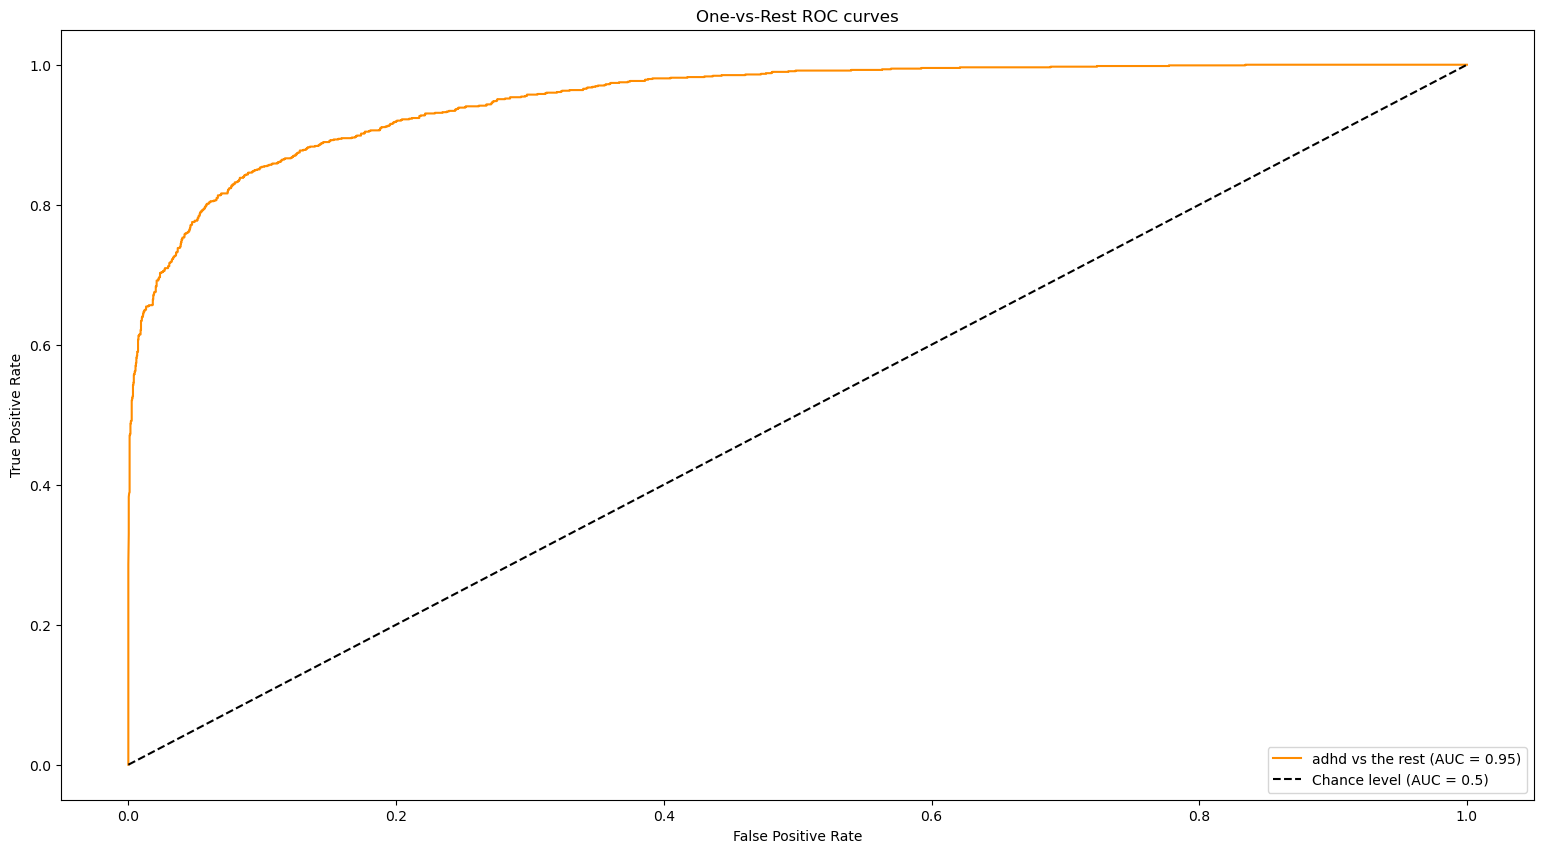

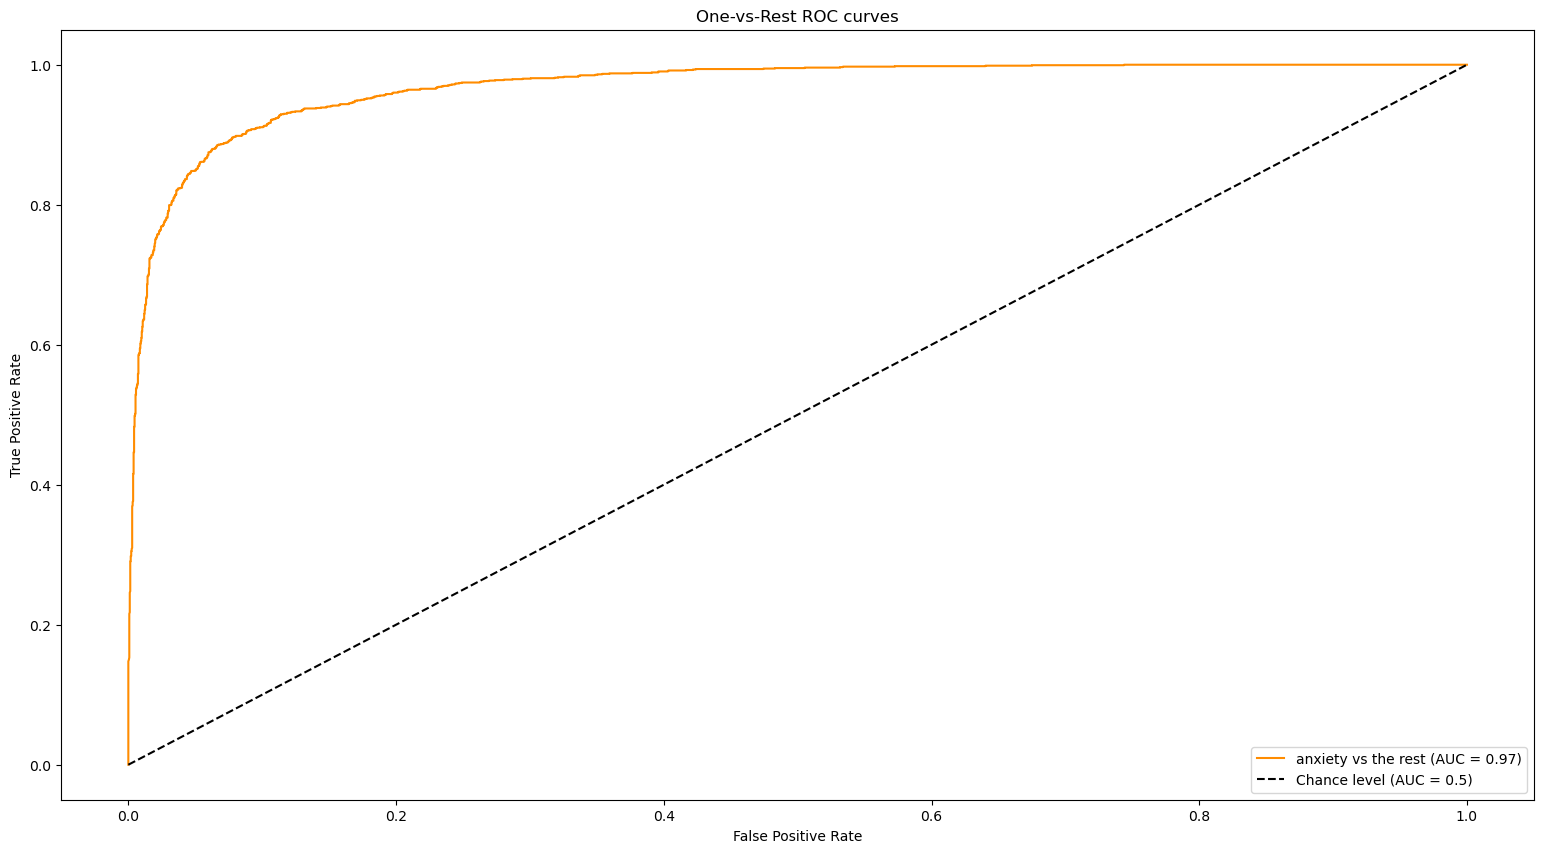

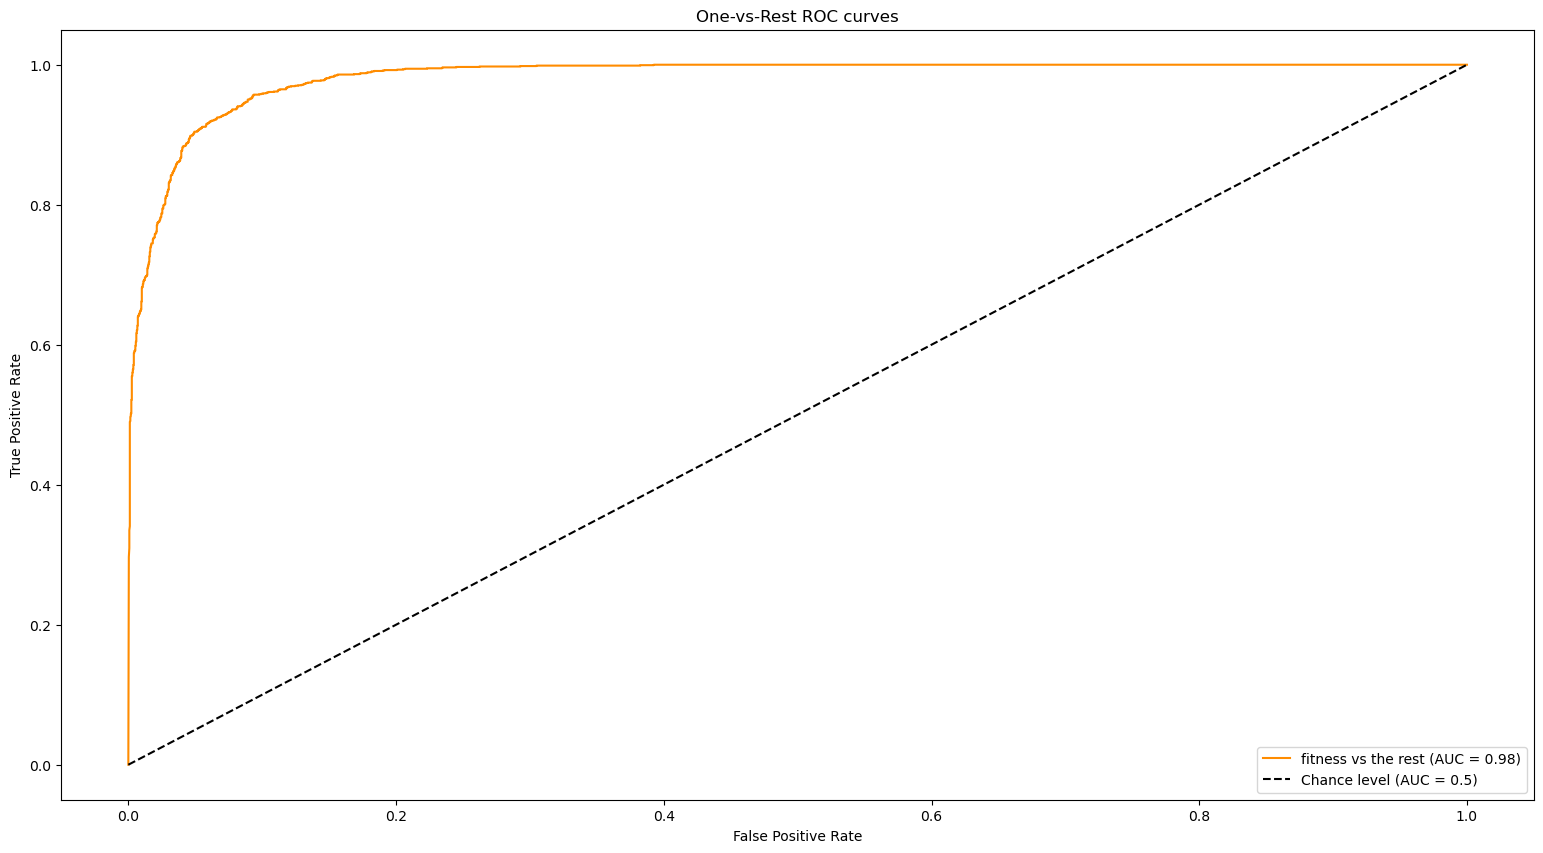

In [62]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

y_pred=tf.nn.softmax(model.predict(X_test)).numpy()

binarizer_true=LabelBinarizer()

binarized_true=binarizer_true.fit_transform(y_test)

lbls={0:'adhd',1:'anxiety',2:'fitness',3:'ptsd'}

for i in range(3):
    display = RocCurveDisplay.from_predictions(
        binarized_true[:,i],
        y_pred[:,i],
        name=f"{lbls[i]} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="One-vs-Rest ROC curves",
    )
    plt.show()

    

#### (Optional) Trying GradientBoostingClassifier to no good result

In [84]:
X_train_cv=X_train.sample(2000)
y_train_cv=y_train.loc[y_train.index.isin(X_train_cv.index)]

list(map(len,[X_train_cv,y_train_cv]))

[2000, 2000]

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

clf=GradientBoostingClassifier(n_estimators=1000, min_samples_split=30, min_samples_leaf=30, max_depth=40, n_iter_no_change=20)
clf.fit(X_train_cv,y_train_cv)
y_pred=clf.predict(X_cv)

In [88]:

accuracy_score(y_cv,y_pred), recall_score(y_cv,y_pred,average='micro'),precision_score(y_cv,y_pred,average='micro')


(0.33866852238459755, 0.33866852238459755, 0.33866852238459755)